#  DIGITAL CURRENCY MARKET (USD & SAR) - Time series
                --daily historical time series--  
                
                
----

## Problem Identification

Forecasting currency stock prices is a challenging task due to different factors. Therefore, it is helpful to build base models for predicting future digital currency trends. Moreover, extracting hidden knowledge and gathering new information can enhance the base models.


### Solution
Build three models to predict the close price of the digital currency stock market.

### Dataset

- This dataset describes daily historical time series for a digital currency (e.g., BTC) traded on a specific market (here, SAR/Sudi Riyal). Prices and volumes are quoted in both the market-specific currency (SAR) and USD. Historical date range: 2018-05-11 to 30.01.2021.

### Data source
 
- Kaggle dataset [DIGITAL CURRENCY MARKET](https://www.kaggle.com/ahmedadam415/digital-currency-time-series)


### Summry

Overall, some challenges are raised while discovering the dataset—one of which, the sudden increase of Close_SAR after July 2020. As a result, we have considered the dates before July 2020 for modelling to get a better prediction. The second challenge was that the RMSE errors were high because of the nature of the stock dataset. 

After applying the models below, The lowest RMSE error was achieved by predicting using the XGBoost model. On the other hand, The highest RMSE error was achieved by forecasting using the XGBoost model. Our findings highlight the difficulty of predicting or forecasting the stock market prices. A better prediction or forecasting might be achieved by having more features and complex models.


|MODEL|RMSE|MEAN|
|:-|:-|:-|
|XGBoost-Prediction|1452.98|35756.13|
|FB Prophet|2642.15|36019.09|
|SARIMAX|2970.51|27715.78|
|XGBoost-Forecasting|3245.0330|35756.13|


**CONTRIBUTORS**

Fahdah Alalyan | Email: fahdah.a15@gmail.com

Amjaad Alsubaie | Email: amjaad_636@hotmail.com

Ahmed Adam | Email: am4ma@hotmail.com

Group Name: Data Miners

----


In [1]:
# Imports
# from mpl_toolkits.mplot3d import Axes3D
# from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from datetime import datetime
from datetime import timedelta
import seaborn as sns

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Loading autocorrelation ACF,PACF,plots, and seasonal decompose

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tools.eval_measures import rmse
from pandas.tseries.frequencies import to_offset

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

from xgboost import XGBRegressor
# from sklearn.model_selection import train_test_split 
from fbprophet import Prophet
from pandas.tseries.frequencies import to_offset

# from fbprophet.diagnostics import cross_validation,
# from fbprophet.diagnostics import performance_metrics


# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
from importlib import reload
reload(plt)

Importing plotly failed. Interactive plots will not work.


<module 'matplotlib.pyplot' from '/Users/fahdahalalyan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

## Functions

In [2]:


def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [3]:
def train_test_split(data,perc):
    data=data.values
    n= int(len(data)*(1-perc))
    return data[:n], data[n:]

##  Data Cleaning and Data Exploration
###  Displaying data

In [5]:
# Read the dataset. 
df= pd.read_csv('../data/dc.csv', parse_dates=['Unnamed: 0']) # Read and convert the Unnamed: 0 column to datetime type.
df.rename(columns={'Unnamed: 0':'date'}, inplace=True) # Rename Unnamed: 0 to date column. 
df.sort_values(by=['date'], inplace=True, ascending=True) # sort based on the date.

In [6]:
df.head(5) # check.

,date,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume
999,2018-05-07,36232.689408,9661.02,36340.138368,9689.67,34432.422400,9181.00,35122.496000,9365.00,33787
998,2018-05-08,35122.496000,9365.00,35537.665280,9475.70,33980.649216,9060.54,34457.025024,9187.56,25533
997,2018-05-09,34421.171200,9178.00,35216.256000,9390.00,33622.336000,8965.00,34916.224000,9310.00,25673
996,2018-05-10,34916.224000,9310.00,35235.458048,9395.12,33641.088000,8970.00,33761.850880,9002.20,25055
995,2018-05-11,33761.888384,9002.21,33816.606720,9016.80,31282.086400,8341.00,31503.360000,8400.00,48227


In [7]:
df.reset_index(drop=True, inplace=True) # reset index.
df.head()

,date,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume
0,2018-05-07,36232.689408,9661.02,36340.138368,9689.67,34432.422400,9181.00,35122.496000,9365.00,33787
1,2018-05-08,35122.496000,9365.00,35537.665280,9475.70,33980.649216,9060.54,34457.025024,9187.56,25533
2,2018-05-09,34421.171200,9178.00,35216.256000,9390.00,33622.336000,8965.00,34916.224000,9310.00,25673
3,2018-05-10,34916.224000,9310.00,35235.458048,9395.12,33641.088000,8970.00,33761.850880,9002.20,25055
4,2018-05-11,33761.888384,9002.21,33816.606720,9016.80,31282.086400,8341.00,31503.360000,8400.00,48227


**Displying the shape of datasets** 

In [8]:
df.shape # check the shape.

(1000, 10)

###  How complete is the data?

Investigating missing values etc.

In [9]:
df.info() # no null values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1000 non-null   datetime64[ns]
 1   open_SAR   1000 non-null   float64       
 2   open_USD   1000 non-null   float64       
 3   high_SAR   1000 non-null   float64       
 4   high_USD   1000 non-null   float64       
 5   low_SAR    1000 non-null   float64       
 6   low_USD    1000 non-null   float64       
 7   close_SAR  1000 non-null   float64       
 8   close_USD  1000 non-null   float64       
 9   volume     1000 non-null   int64         
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 78.2 KB


In [10]:
df.isna().sum() # get the numbers of null values. 

date         0
open_SAR     0
open_USD     0
high_SAR     0
high_USD     0
low_SAR      0
low_USD      0
close_SAR    0
close_USD    0
volume       0
dtype: int64

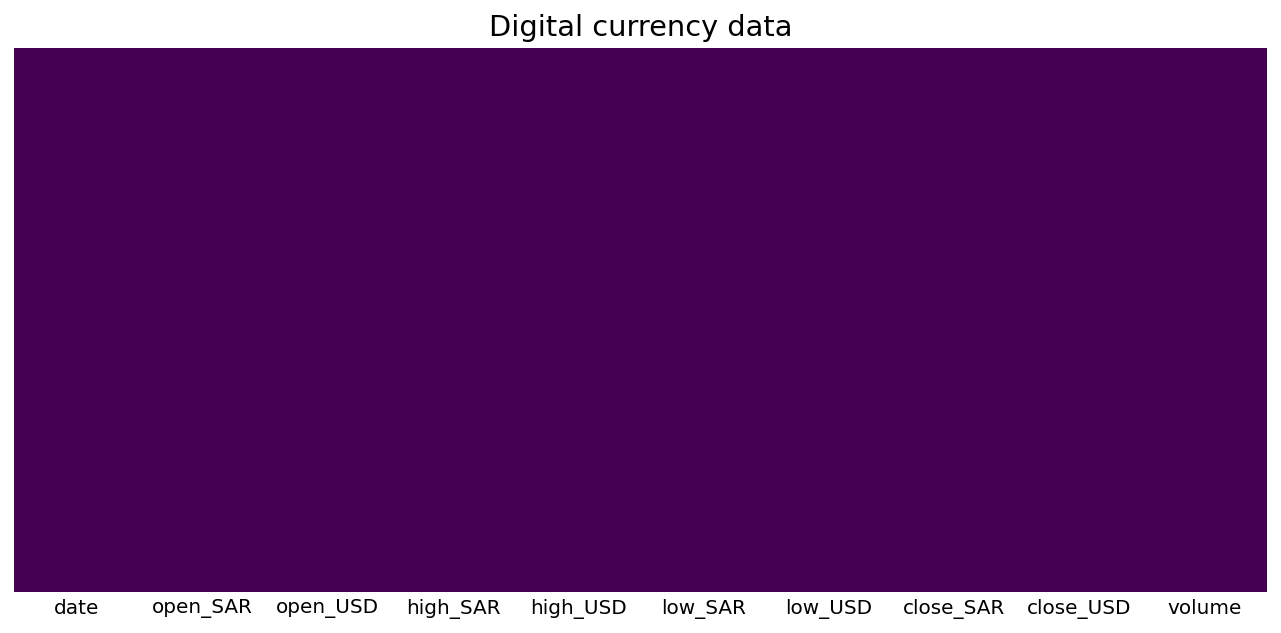

In [11]:
# Another way of visualize null values.
fig, ax = plt.subplots(figsize = (10,5))

# train data 
sns.heatmap(df.isnull(), yticklabels=False, ax = ax, cbar=False, cmap='viridis')
ax.set_title('Digital currency data');


###  Investigating data types
Displaying the data types of each feature. 

In [12]:
df.dtypes # the data type is good.
# We do not need to rename the column names.

date         datetime64[ns]
open_SAR            float64
open_USD            float64
high_SAR            float64
high_USD            float64
low_SAR             float64
low_USD             float64
close_SAR           float64
close_USD           float64
volume                int64
dtype: object

### Creating a data dictionary


|Feature|Type|Dataset|Description|
|:-|:-|:-|:------------:|
|date|*datetime*|dc|Date|
|open_SAR|*float*|dc|Opening price Saudi Riyal(SAR)|
|open_USD|*float*|dc|Opening price (USD)|
|high_SAR|*float*|dc|Highest stock price (SAR)|
|high_USD|*float*|dc|Highest stock price (USD)|
|low_SAR|*float*|dc|lowest stock price (SAR)|
|low_USD|*float*|dc|lowest stock price (USD)|
|close_SAR|*float*|dc|Market closing stock price (SAR)|
|close_USD|*float*|dc|Market closing stock price (USD)|
|volume|*int*|dc|Trading volume|

####  - Statistical Measures

In [13]:
df.describe() # obtaining the statiscal measures. 

,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,34825.322255,9285.762120,35789.618165,9542.880270,33796.329057,9011.393200,34917.483572,9310.335850,53100.498000
std,21728.028028,5793.522832,22785.946842,6075.604427,20565.410145,5483.524463,21928.280072,5846.917681,35329.832031
min,12045.197184,3211.710000,12288.185600,3276.500000,11837.237504,3156.260000,12045.234688,3211.720000,5743.000000
25%,24254.558752,6467.192500,24686.089152,6582.255000,23721.336256,6325.015000,24252.946080,6466.762500,30045.750000
50%,30714.632128,8189.695000,31321.953152,8351.630000,30010.869568,8002.045000,30713.263232,8189.330000,43795.500000
75%,38317.311744,10216.860000,39077.527200,10419.562500,37158.878816,9907.977500,38329.725568,10220.170000,64909.250000
max,152217.334784,40586.960000,157329.280000,41950.000000,145215.488000,38720.000000,152201.770624,40582.810000,402201.000000


### Visualization

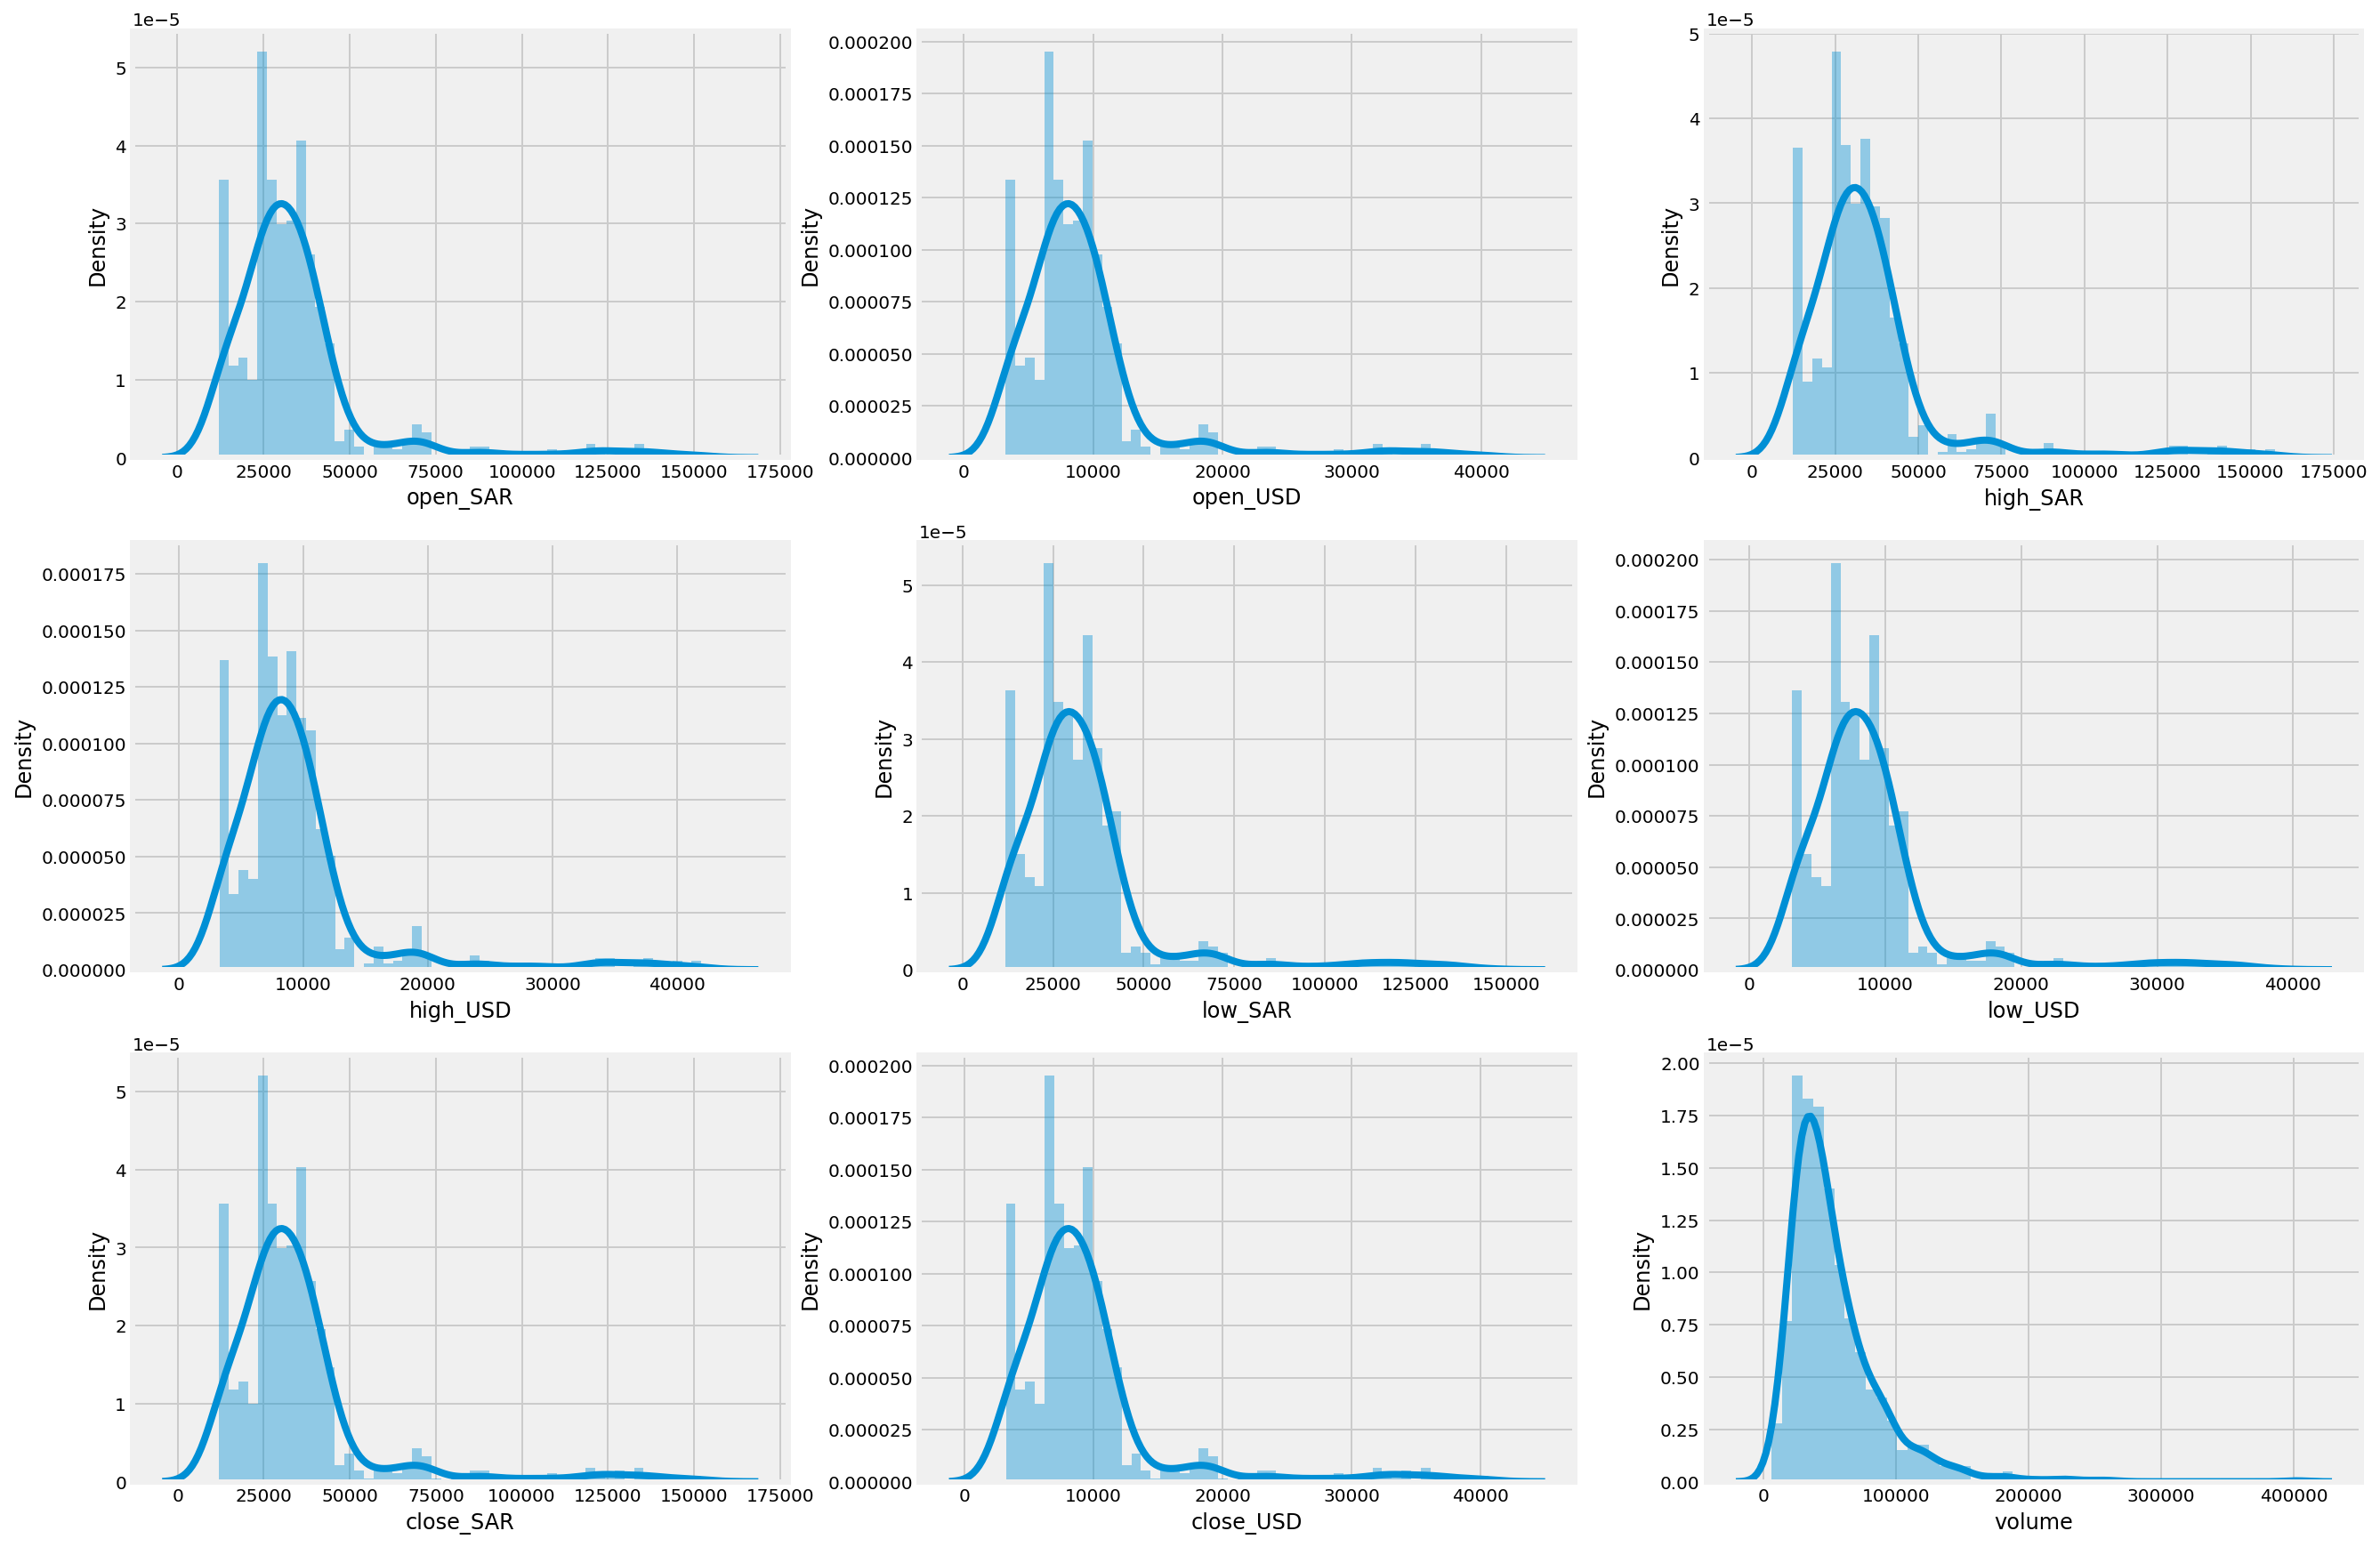

In [14]:
# plotting the distribution for each column.
# postive skew, it is not normal distributions. 
# We can noticed that from the distribution plots.

fig, ax = plt.subplots(nrows=3,ncols=3,figsize = (20,15)) #18,15

sns.distplot(df.open_SAR, ax= ax[0][0])
sns.distplot(df.open_USD, ax= ax[0][1])
sns.distplot(df.high_SAR, ax= ax[0][2])

sns.distplot(df.high_USD, ax= ax[1][0])
sns.distplot(df.low_SAR, ax= ax[1][1])
sns.distplot(df.low_USD, ax= ax[1][2])


sns.distplot(df.close_SAR, ax= ax[2][0])
sns.distplot(df.close_USD, ax= ax[2][1])
sns.distplot(df.volume, ax= ax[2][2]);


In [15]:
acf(df['close_SAR'],nlags=100) # displaying the close_SAR (100 days) ago.

array([1.        , 0.98771005, 0.97517924, 0.96339825, 0.95414099,
       0.9429481 , 0.93172193, 0.91946539, 0.90742227, 0.89493068,
       0.88412952, 0.86972779, 0.85429913, 0.83762017, 0.82202661,
       0.80656295, 0.7902845 , 0.77208829, 0.75510338, 0.74100794,
       0.72585028, 0.70871152, 0.69015889, 0.67110579, 0.65257484,
       0.63632649, 0.62221476, 0.609555  , 0.59590041, 0.58263247,
       0.5714892 , 0.56092943, 0.54990114, 0.54002603, 0.53028644,
       0.52107628, 0.51180948, 0.50414172, 0.49705091, 0.49012521,
       0.48254236, 0.47565971, 0.46827413, 0.46061211, 0.45322566,
       0.44560663, 0.43890309, 0.43343907, 0.4277883 , 0.42236719,
       0.41740621, 0.41276285, 0.40758649, 0.4025466 , 0.39774956,
       0.39222707, 0.38629441, 0.38032564, 0.37466372, 0.36841737,
       0.36202321, 0.35610453, 0.34957321, 0.34408243, 0.33881556,
       0.33422154, 0.32959899, 0.32384758, 0.31787321, 0.31260818,
       0.30706665, 0.30104536, 0.29505387, 0.28963666, 0.28405

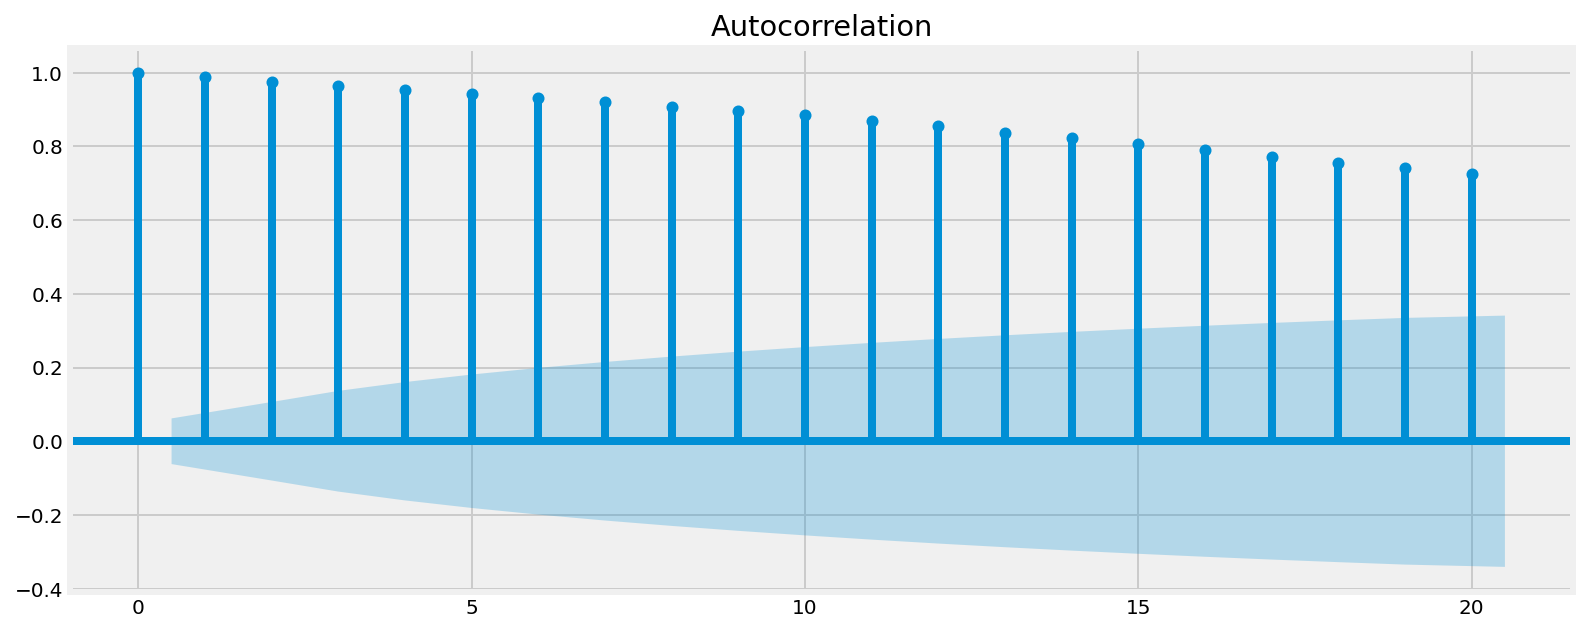

In [16]:
# plotting the autocorrelation of the close_SAR column.
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(df['close_SAR'], lags=20, ax=ax) 
plt.show()

<AxesSubplot:xlabel='date'>

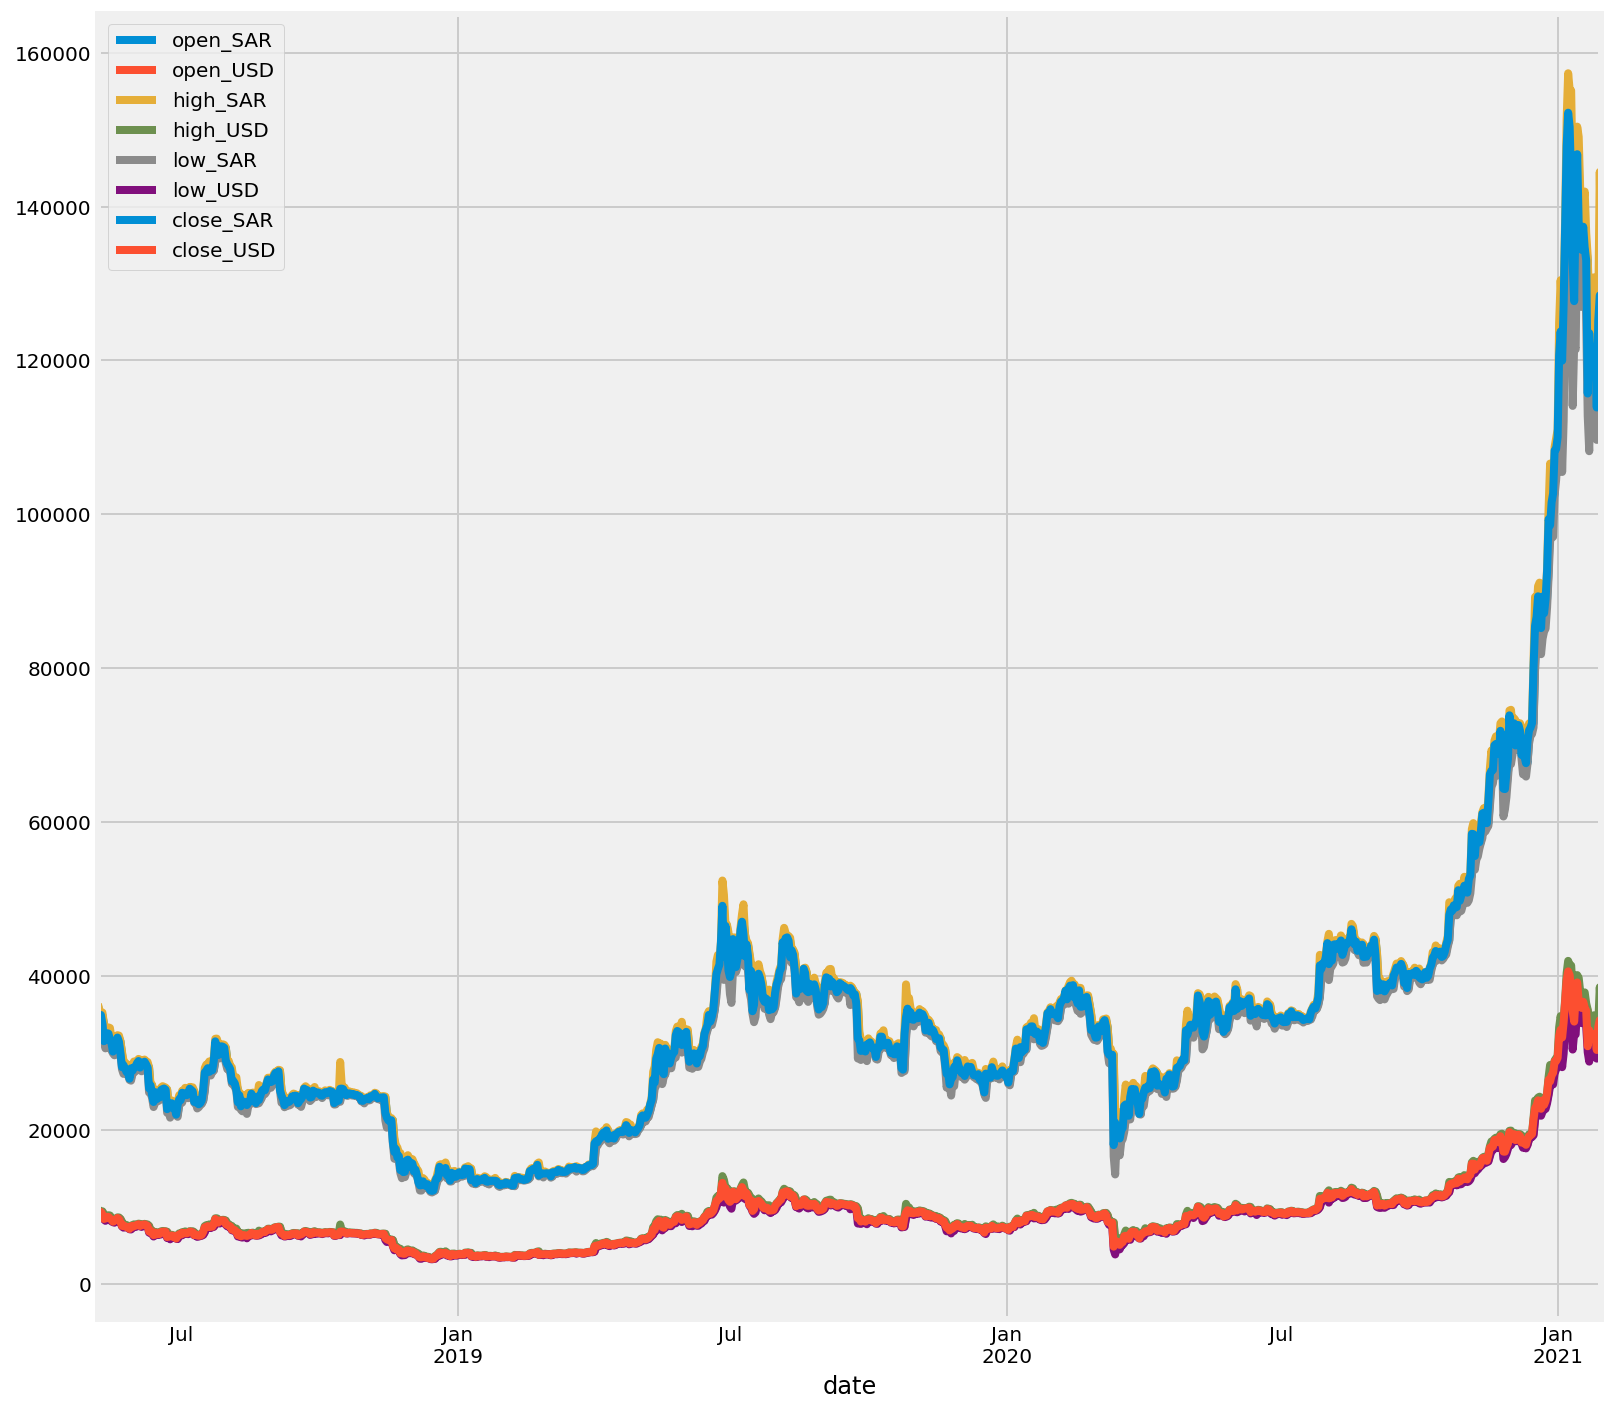

In [16]:
# overall data plot
fig, ax = plt.subplots(figsize=(12, 12))
df.iloc[:,:-1].plot(x= 'date', ax= ax)

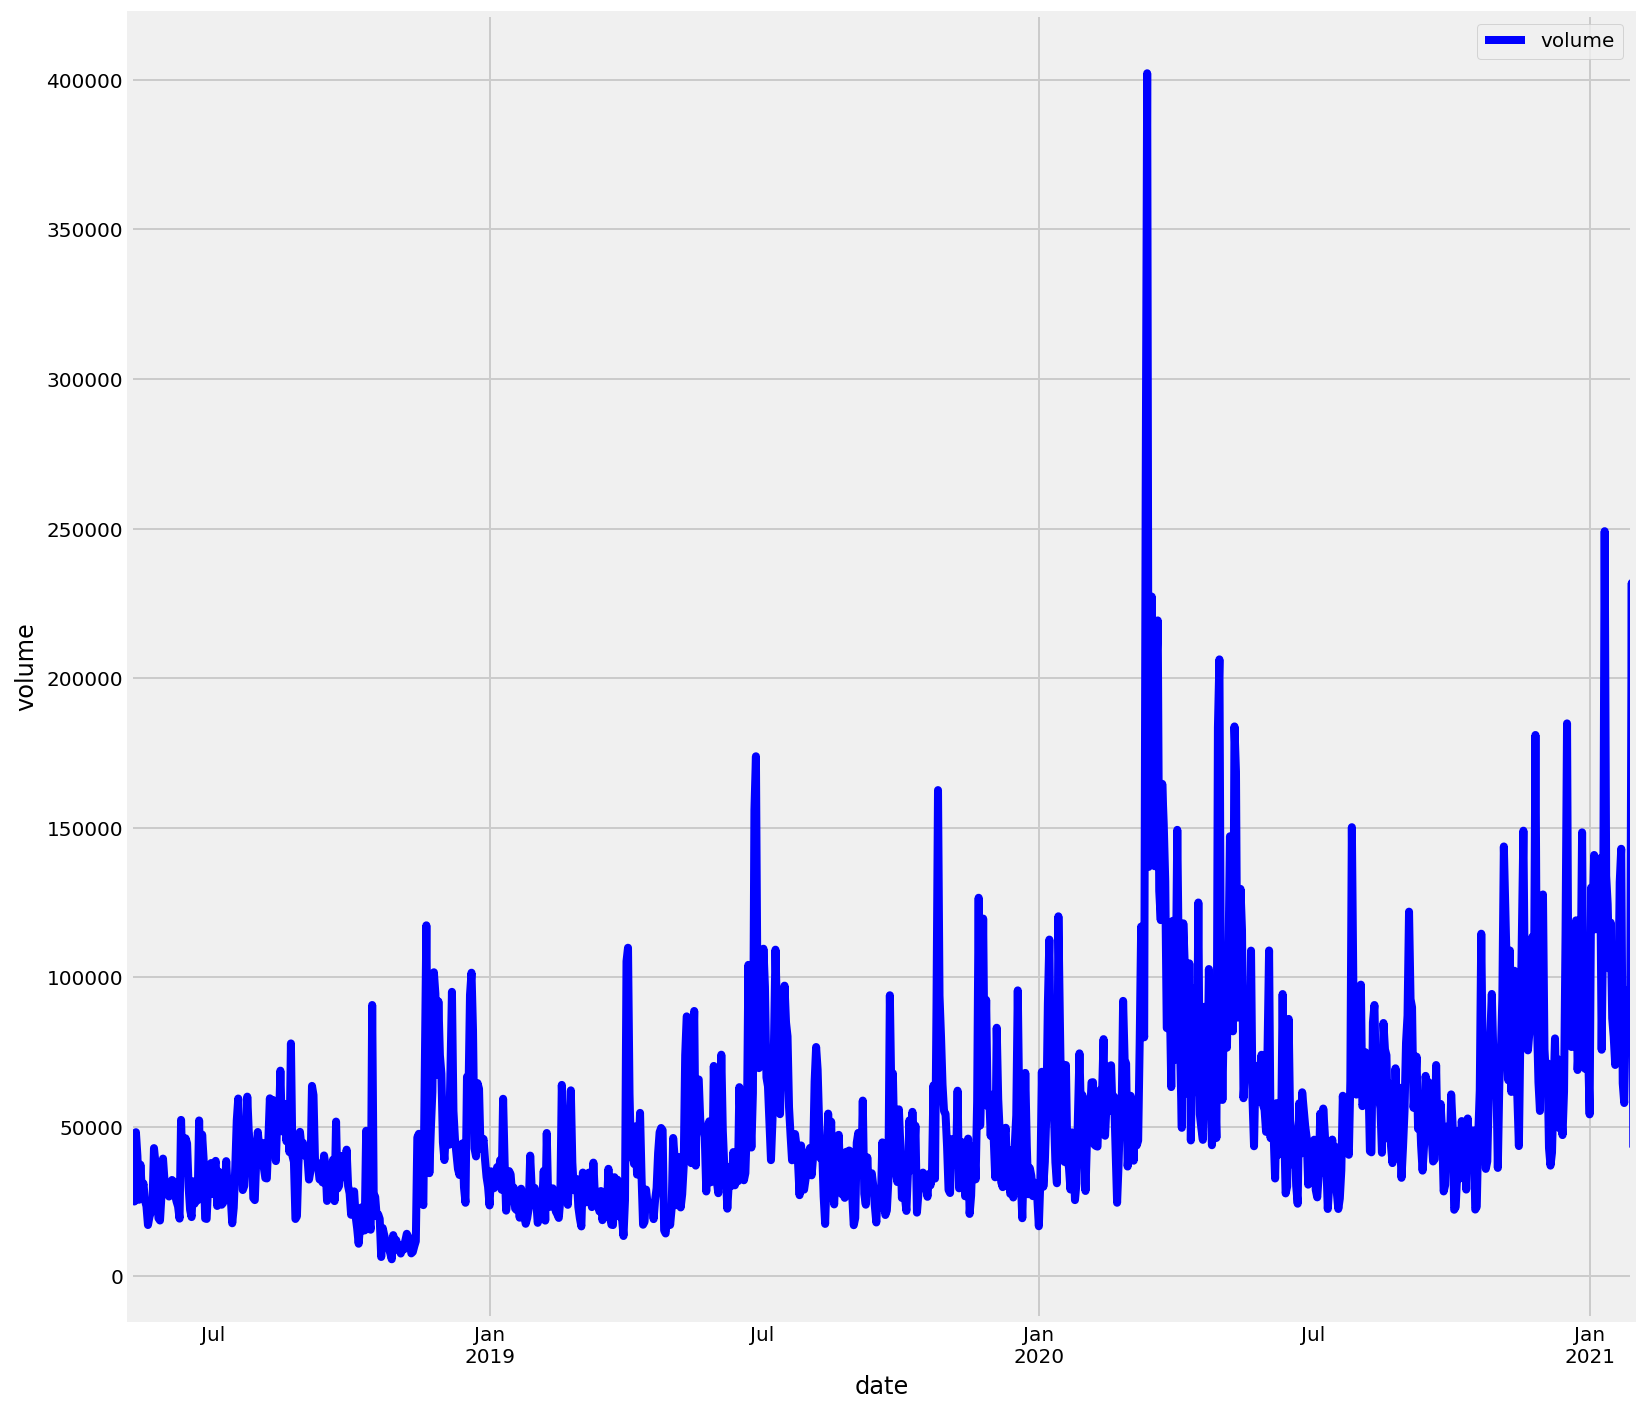

In [17]:
# plotting Volume.
fig, ax = plt.subplots(figsize=(12, 12)) 
df.plot(x='date',y='volume', c='b', ax= ax)
ax.set_ylabel('volume');

We noticed that there is a sudden increase after August 2020, which may negatively affect the prediction. Therefore, we have selected a slice of data from the dataset's start date (2018-05-07) to (2020-07-31).  

In [18]:
before=df.loc[df['date']<'8/01/2020'] # a slice of data from the dataset's start date (2018-05-07) to (2020-07-31).
before.head()

,date,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume
0,2018-05-07,36232.689408,9661.02,36340.138368,9689.67,34432.422400,9181.00,35122.496000,9365.00,33787
1,2018-05-08,35122.496000,9365.00,35537.665280,9475.70,33980.649216,9060.54,34457.025024,9187.56,25533
2,2018-05-09,34421.171200,9178.00,35216.256000,9390.00,33622.336000,8965.00,34916.224000,9310.00,25673
3,2018-05-10,34916.224000,9310.00,35235.458048,9395.12,33641.088000,8970.00,33761.850880,9002.20,25055
4,2018-05-11,33761.888384,9002.21,33816.606720,9016.80,31282.086400,8341.00,31503.360000,8400.00,48227


In [19]:
before.set_index('date',inplace=True,drop=True) # setting the date as index.
before.index.freq = 'D' 

In [20]:
before.head()

,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume
date,,,,,,,,,
2018-05-07,36232.689408,9661.02,36340.138368,9689.67,34432.422400,9181.00,35122.496000,9365.00,33787
2018-05-08,35122.496000,9365.00,35537.665280,9475.70,33980.649216,9060.54,34457.025024,9187.56,25533
2018-05-09,34421.171200,9178.00,35216.256000,9390.00,33622.336000,8965.00,34916.224000,9310.00,25673
2018-05-10,34916.224000,9310.00,35235.458048,9395.12,33641.088000,8970.00,33761.850880,9002.20,25055
2018-05-11,33761.888384,9002.21,33816.606720,9016.80,31282.086400,8341.00,31503.360000,8400.00,48227


<AxesSubplot:xlabel='date'>

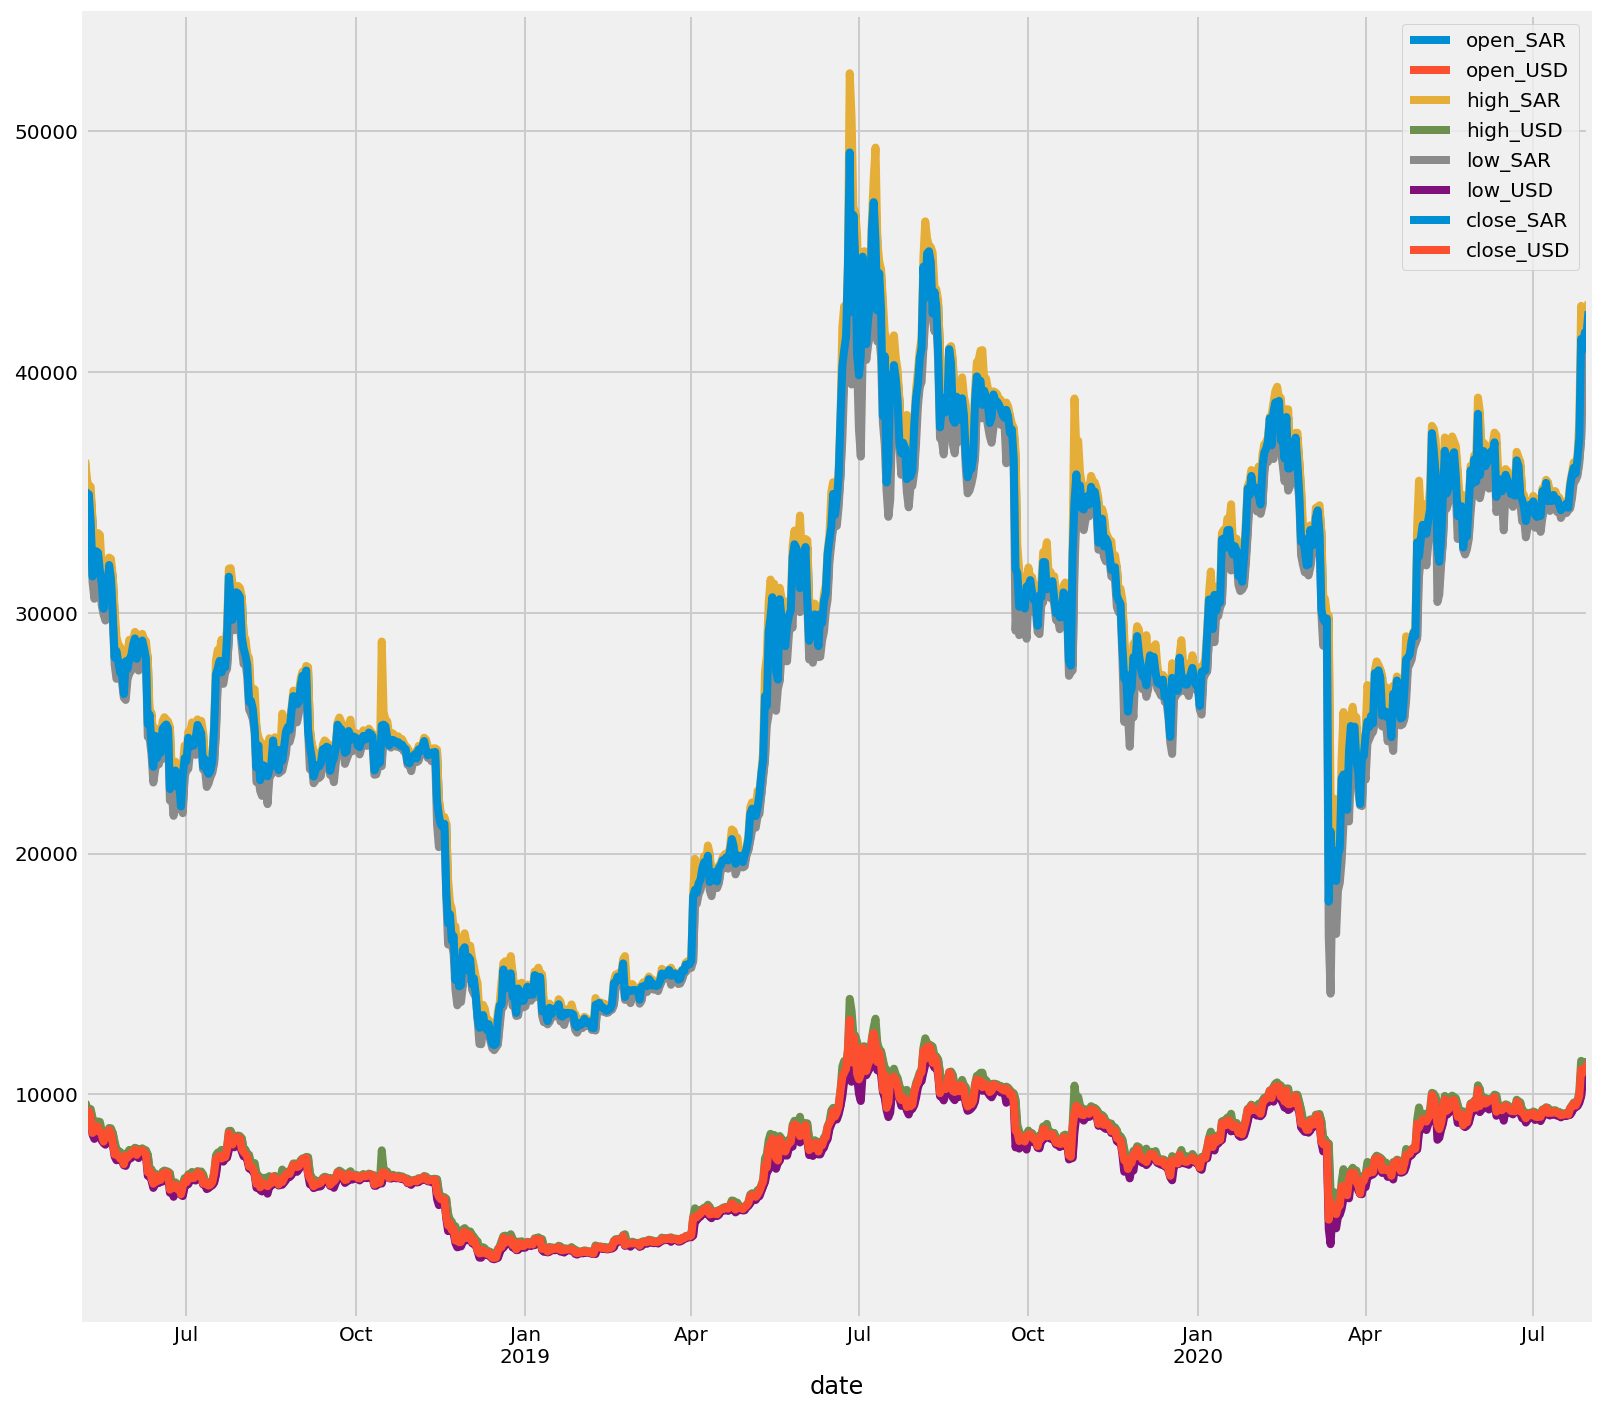

In [21]:
# overall data plot from (2018-05-07) to (2020-07-31).
fig, ax = plt.subplots(figsize=(12, 12))
before.iloc[:,:-1].plot(ax= ax)

<!-- Distribution graphs (histogram/bar graph) of sampled columns: -->

<!-- Correlation matrix: -->

<!-- Scatter and density plots: -->

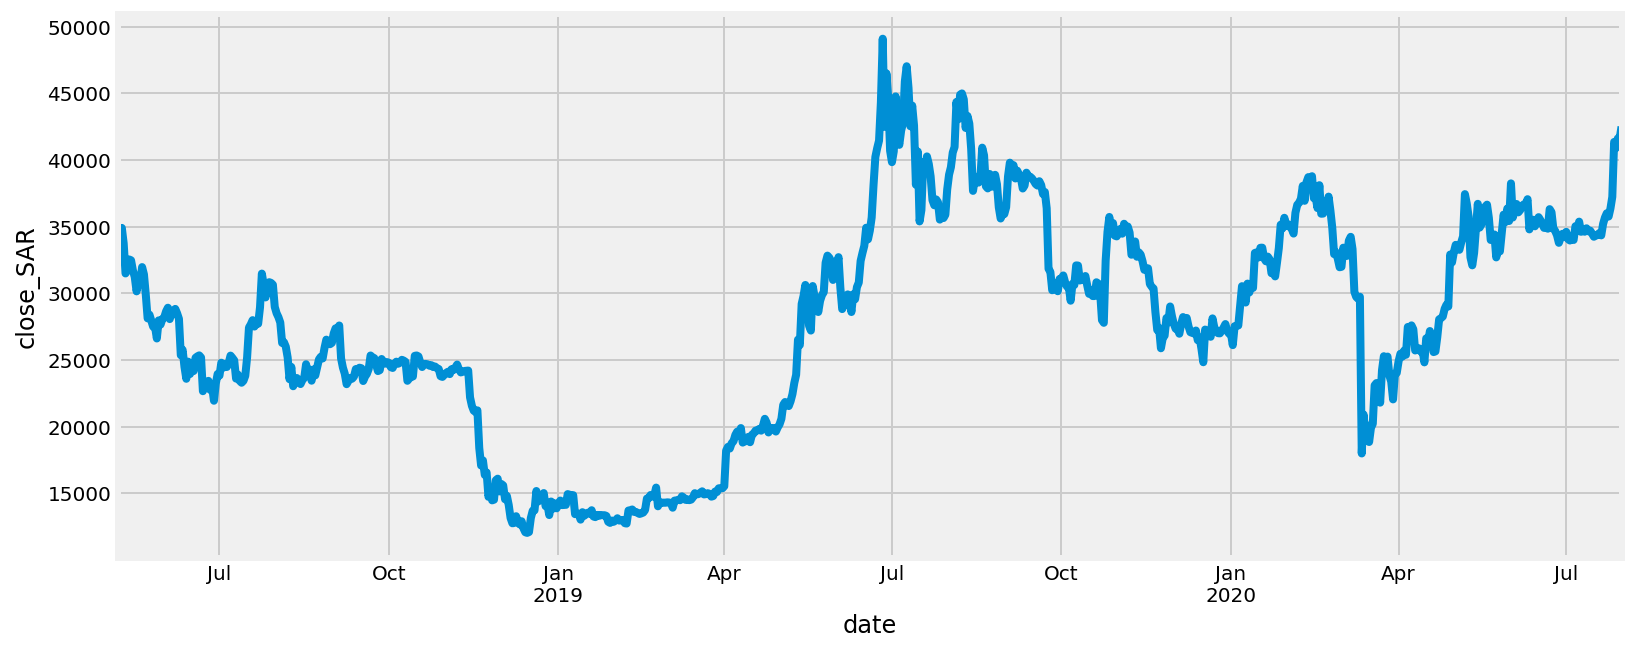

In [22]:
# plotting the target.
ax = before['close_SAR'].plot(figsize=(12, 5))
ax.set_ylabel('close_SAR');
plt.show()

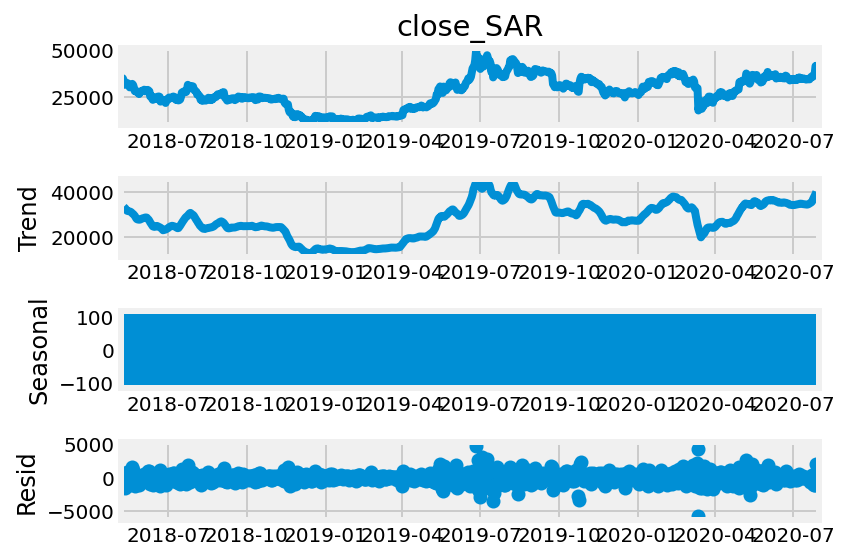

In [23]:
# check the seasonality.
result = seasonal_decompose(before['close_SAR'])
result.plot();

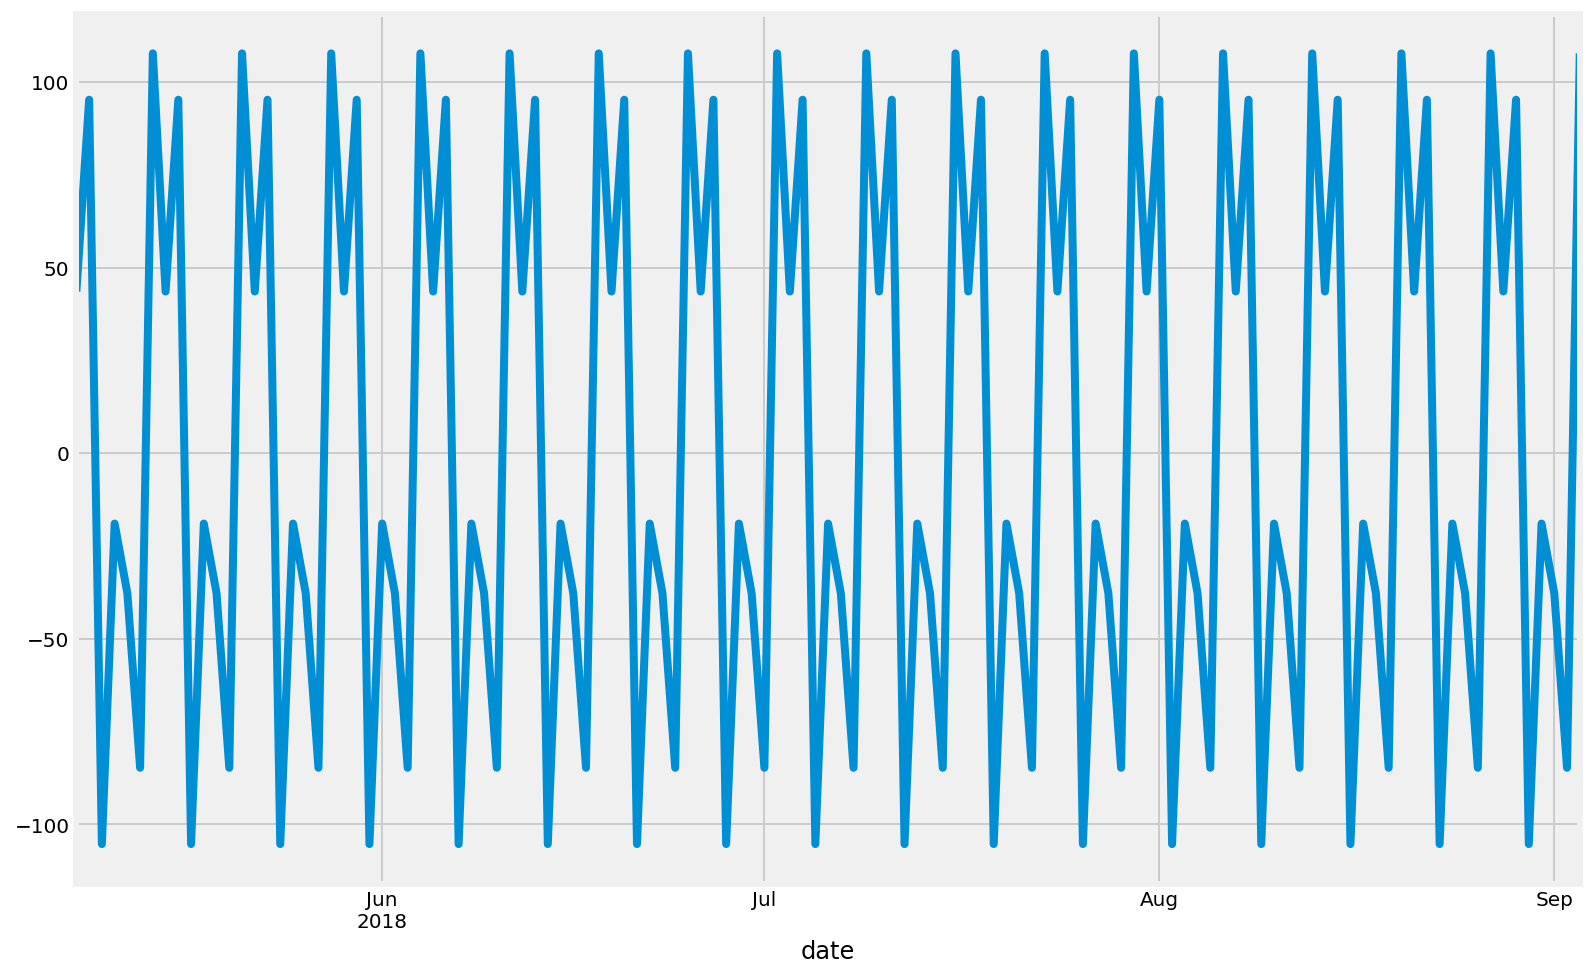

In [24]:
# plot the seasonlity in a higher scale
ax=result.seasonal[1:120].plot(figsize=(12,8))

### Check if stationary

In [25]:
adf_test(before['close_SAR']) # it is non-stationary.

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.537739
p-value                   0.514767
# lags used               2.000000
# observations          814.000000
critical value (1%)      -3.438409
critical value (5%)      -2.865097
critical value (10%)     -2.568664
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


----------

## Modelling

### 1. SARIMAX

In [26]:
auto_arima(before['close_SAR'],seasonal=True,m=7).summary() # m is based on observing the seasonlity from the above plot. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  817
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -6888.112
Date:                Wed, 10 Feb 2021   AIC                          13780.225
Time:                        17:36:22   BIC                          13789.634
Sample:                             0   HQIC                         13783.836
                                - 817                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0792      0.020     -3.900      0.000      -0.119      -0.039
sigma2      1.258e+06   1.97e+04     63.929      0.000    1.22e+06     1.3e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):             11639.14
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               2.81   Skew:                            -1.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
# to split the dataset to train and test
# 30 days as test while the remaining is the train.

len(before)-30 # to get the remaining dataset length (787).

# Set 30 days for testing
df_train = before.iloc[:787]
df_test = before.iloc[787:]

len(df_train),len(df_test)

(787, 30)

In [28]:
model1 = SARIMAX(df_train['close_SAR'],order=(1,1,0))
results1 = model1.fit()
results1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              close_SAR   No. Observations:                  787
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -6640.318
Date:                Wed, 10 Feb 2021   AIC                          13284.637
Time:                        17:36:38   BIC                          13293.971
Sample:                    05-07-2018   HQIC                         13288.225
                         - 07-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0804      0.021     -3.903      0.000      -0.121      -0.040
sigma2      1.275e+06   2.04e+04     62.652      0.000    1.24e+06    1.32e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):             11120.86
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               2.92   Skew:                            -1.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Prediction

In [29]:
# prediction
start=len(df_train)
end=len(df_train)+len(df_test)-1
predictions1 = results1.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,1,0) Predictions')

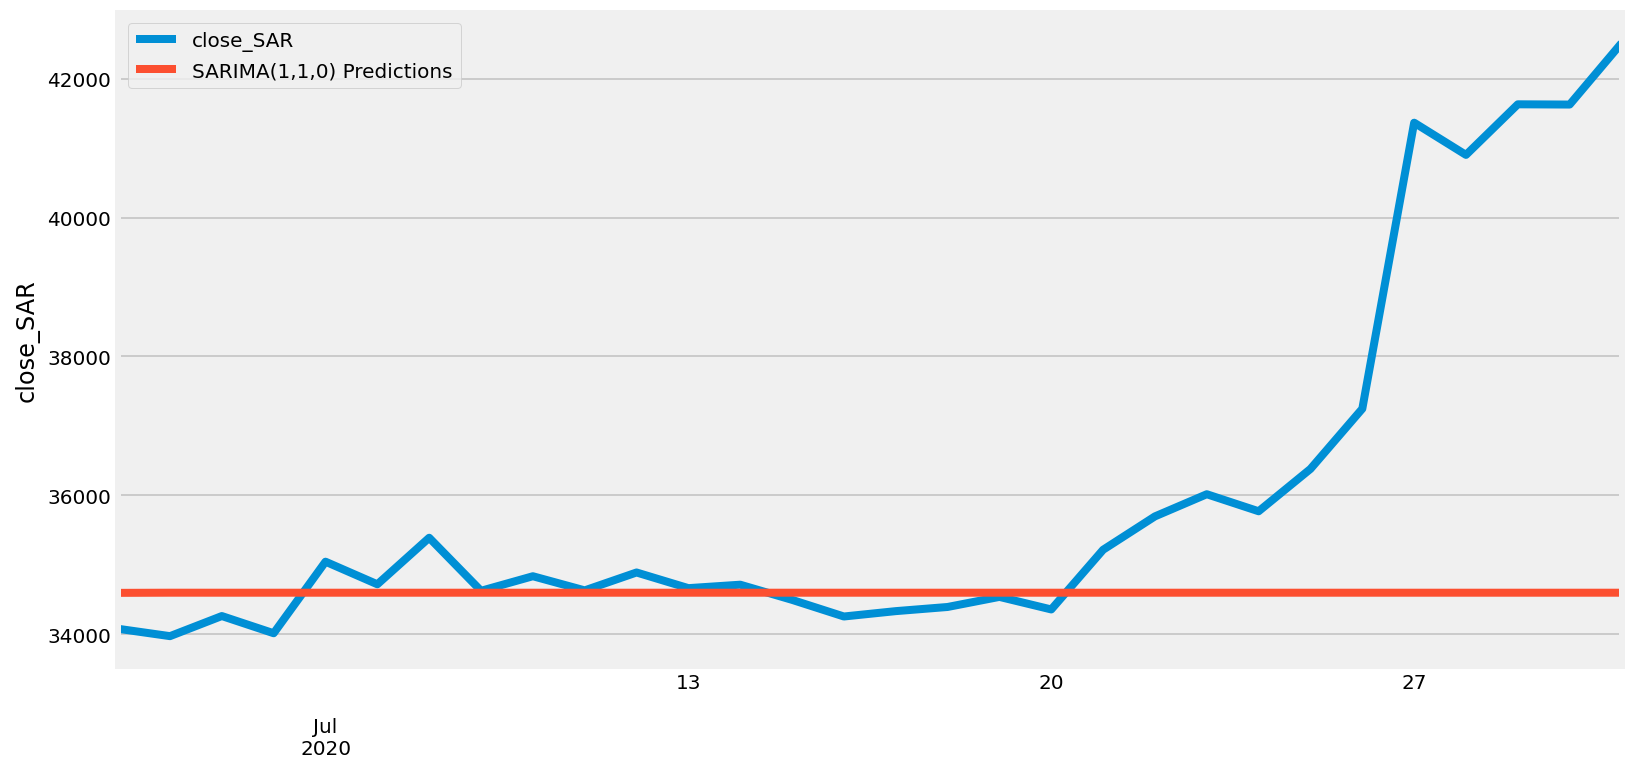

In [30]:
# Plot predictions against known values
title = ''
ylabel='close_SAR'
xlabel=''

ax = df_test['close_SAR'].plot(legend=True,figsize=(12,6))
predictions1.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);


In [31]:
# RMSE Error
error1 = rmse(df_test['close_SAR'], predictions1)
print(f'SARIMAX(1,0,0) RMSE Error: {error1:4.8}')
print('The mean of Close_SAR:',before['close_SAR'].mean())


SARIMAX(1,0,0) RMSE Error: 2970.5125
The mean of Close_SAR: 27715.786237179942


### Forecasting

In [32]:
# Forecasting
fcast1 = results1.predict(start=len(before),end=len(before)+30,typ='levels',dynamic=False).rename('SARIMA(1,1,0) Forecast')

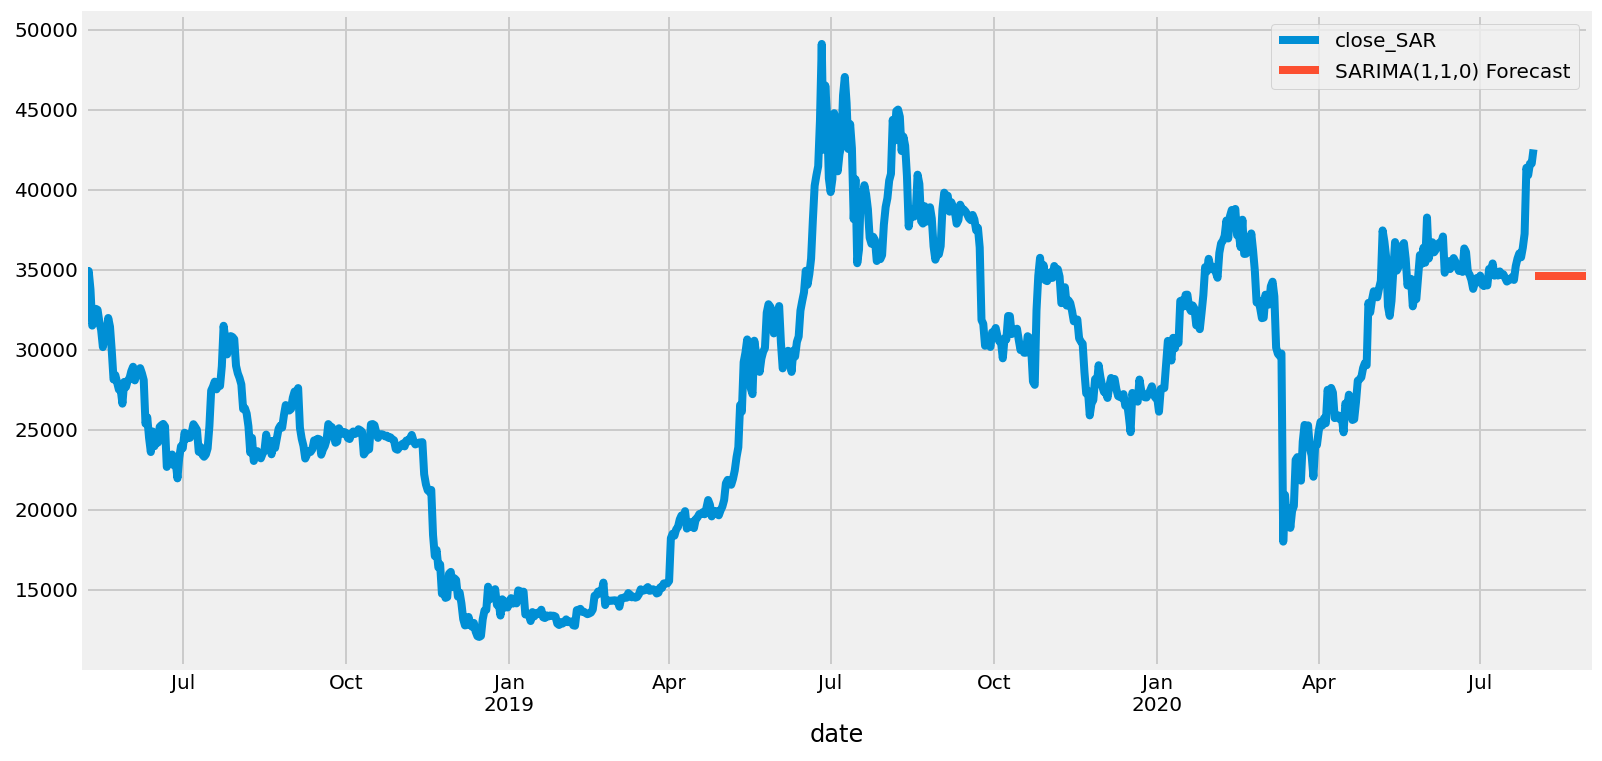

In [33]:
# plot forcasting
title = ''
ax = before['close_SAR'].plot(legend=True,figsize=(12,6),title=title)
fcast1.plot(legend=True);


---------
### 2. Facebook prophet

In [34]:
#We made a copy of the dataframe to change the columns' name to y and ds to satisfy the Facebook prophet requirement.ds_train = df_train.copy()
ds_train = df_train.copy()
ds_train = ds_train.rename(columns={'close_SAR': 'y'}) # rename close_SAR' to 'y'
ds_train['ds'] = df_train.index  # new column as ds, which contains the date (index).
ds_train.head()

,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,y,close_USD,volume,ds
date,,,,,,,,,,
2018-05-07,36232.689408,9661.02,36340.138368,9689.67,34432.422400,9181.00,35122.496000,9365.00,33787,2018-05-07
2018-05-08,35122.496000,9365.00,35537.665280,9475.70,33980.649216,9060.54,34457.025024,9187.56,25533,2018-05-08
2018-05-09,34421.171200,9178.00,35216.256000,9390.00,33622.336000,8965.00,34916.224000,9310.00,25673,2018-05-09
2018-05-10,34916.224000,9310.00,35235.458048,9395.12,33641.088000,8970.00,33761.850880,9002.20,25055,2018-05-10
2018-05-11,33761.888384,9002.21,33816.606720,9016.80,31282.086400,8341.00,31503.360000,8400.00,48227,2018-05-11


In [35]:
ds_test = df_test.copy() 
ds_test['ds'] = df_test.index # new column as ds, which contains the date (index).
ds_test = ds_test.rename(columns={'close_SAR': 'y'}) # rename close_SAR' to 'y'
ds_test.head()

,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,y,close_USD,volume,ds
date,,,,,,,,,,
2020-07-02,34623.655296,9231.99,34736.054784,9261.96,33528.576000,8940.00,34078.159616,9086.54,45725,2020-07-02
2020-07-03,34078.159616,9086.54,34222.400000,9125.00,33894.127488,9037.47,33972.098304,9058.26,28943,2020-07-03
2020-07-04,33970.335616,9057.79,34466.176000,9190.00,33903.766016,9040.04,34261.629184,9135.46,26441,2020-07-04
2020-07-05,34259.904000,9135.00,34298.308096,9145.24,33352.419712,8893.03,34013.915264,9069.41,34073,2020-07-05
2020-07-06,34013.915264,9069.41,35160.000000,9375.00,33963.322368,9055.92,35044.487680,9344.20,54463,2020-07-06


In [36]:
train= ds_train.drop(columns=['open_SAR','open_USD', 'high_SAR', 'high_USD', 'low_SAR','close_USD','volume', 'low_USD'])
train.head()

,y,ds
date,,
2018-05-07,35122.496000,2018-05-07
2018-05-08,34457.025024,2018-05-08
2018-05-09,34916.224000,2018-05-09
2018-05-10,33761.850880,2018-05-10
2018-05-11,31503.360000,2018-05-11


In [37]:
test= ds_test.drop(columns=['open_SAR','open_USD', 'high_SAR', 'high_USD', 'low_SAR','close_USD','volume', 'low_USD'])
test.head()

,y,ds
date,,
2020-07-02,34078.159616,2020-07-02
2020-07-03,33972.098304,2020-07-03
2020-07-04,34261.629184,2020-07-04
2020-07-05,34013.915264,2020-07-05
2020-07-06,35044.487680,2020-07-06


In [38]:
## FB prophet model
model2 = Prophet()
model2.fit(train)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### prediction

In [39]:
# predictions
pred2 = model2.predict(test)
pred2.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-07-02,31615.398341,33933.596780,40066.922787,31615.398341,31615.398341,5231.978906,5231.978906,5231.978906,-98.946948,-98.946948,-98.946948,5330.925855,5330.925855,5330.925855,0.0,0.0,0.0,36847.377248
1,2020-07-03,31599.871555,33890.596311,39906.733809,31599.871555,31599.871555,5333.725798,5333.725798,5333.725798,-13.721658,-13.721658,-13.721658,5347.447456,5347.447456,5347.447456,0.0,0.0,0.0,36933.597352
2,2020-07-04,31584.344768,33903.530954,39919.028971,31584.344768,31584.344768,5312.491726,5312.491726,5312.491726,-43.628127,-43.628127,-43.628127,5356.119852,5356.119852,5356.119852,0.0,0.0,0.0,36896.836493
3,2020-07-05,31568.817981,33906.436594,39684.837707,31568.817981,31568.817981,5254.927656,5254.927656,5254.927656,-104.269269,-104.269269,-104.269269,5359.196924,5359.196924,5359.196924,0.0,0.0,0.0,36823.745637
4,2020-07-06,31553.291194,34085.706261,40187.325123,31553.291194,31553.291194,5477.839736,5477.839736,5477.839736,118.890907,118.890907,118.890907,5358.948829,5358.948829,5358.948829,0.0,0.0,0.0,37031.130930


<AxesSubplot:xlabel='ds'>

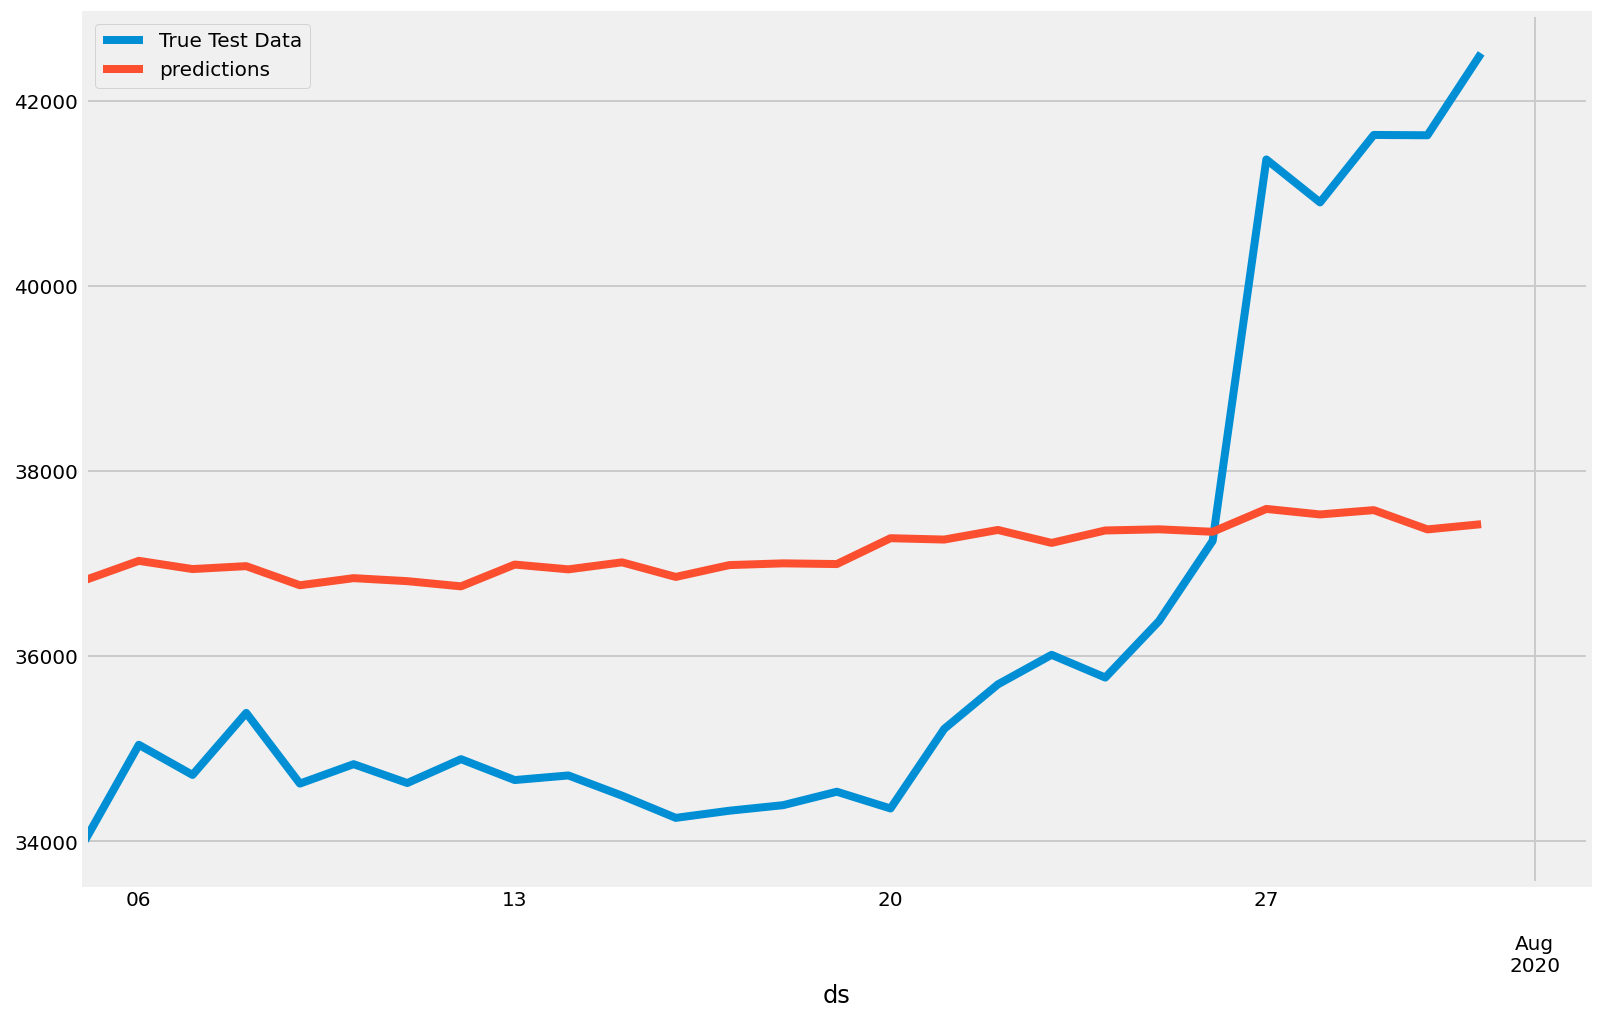

In [40]:
# Plot predictions against test values 
ax=test.plot(x='ds',y='y',legend=True,label='True Test Data',figsize=(12,8)) # yhat = predict close_SAR
pred2.plot(x='ds',y='yhat',legend=True,label='predictions',ax=ax,xlim=('2020-07-05','2020-08-02'))



### Forecast

In [41]:
## FB prophet forecast

future2=model2.make_future_dataframe(periods=30,freq='D', include_history=False)
forecast2=model2.predict(future2)
forecast2.head()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-07-02,31615.398341,33652.002512,39883.865202,31615.398341,31615.398341,5231.978906,5231.978906,5231.978906,-98.946948,-98.946948,-98.946948,5330.925855,5330.925855,5330.925855,0.0,0.0,0.0,36847.377248
1,2020-07-03,31599.871555,34105.617086,40002.547589,31599.871555,31599.871555,5333.725798,5333.725798,5333.725798,-13.721658,-13.721658,-13.721658,5347.447456,5347.447456,5347.447456,0.0,0.0,0.0,36933.597352
2,2020-07-04,31584.344768,33789.695549,39946.417633,31584.344768,31584.344768,5312.491726,5312.491726,5312.491726,-43.628127,-43.628127,-43.628127,5356.119852,5356.119852,5356.119852,0.0,0.0,0.0,36896.836493
3,2020-07-05,31568.817981,33702.071415,39699.241212,31568.817981,31568.817981,5254.927656,5254.927656,5254.927656,-104.269269,-104.269269,-104.269269,5359.196924,5359.196924,5359.196924,0.0,0.0,0.0,36823.745637
4,2020-07-06,31553.291194,34230.620223,40071.963565,31553.291194,31553.291194,5477.839736,5477.839736,5477.839736,118.890907,118.890907,118.890907,5358.948829,5358.948829,5358.948829,0.0,0.0,0.0,37031.130930


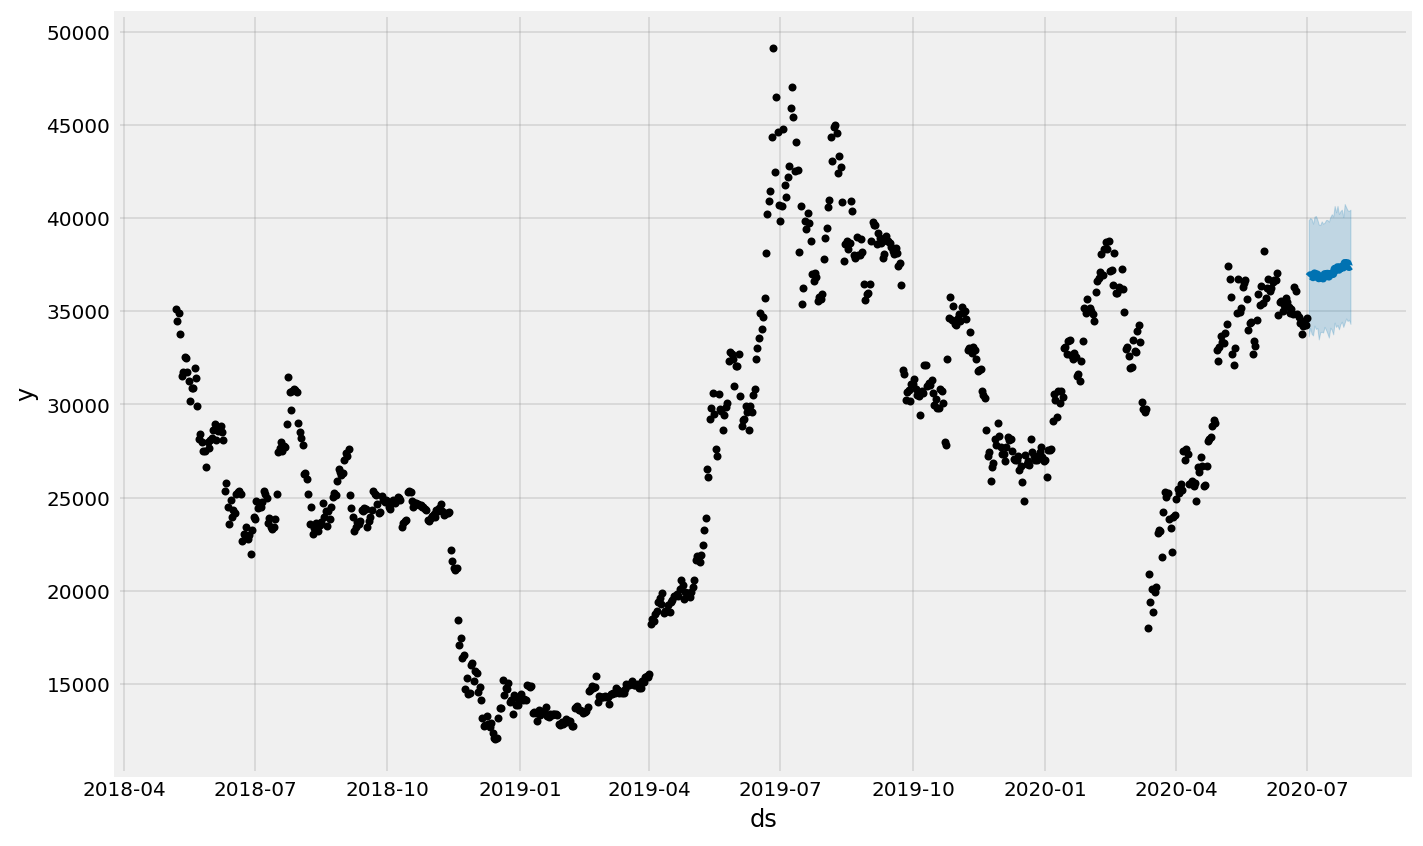

In [42]:
# plotting the model (the dataset and forecast)
model2.plot(forecast2, uncertainty=True)
plt.show()

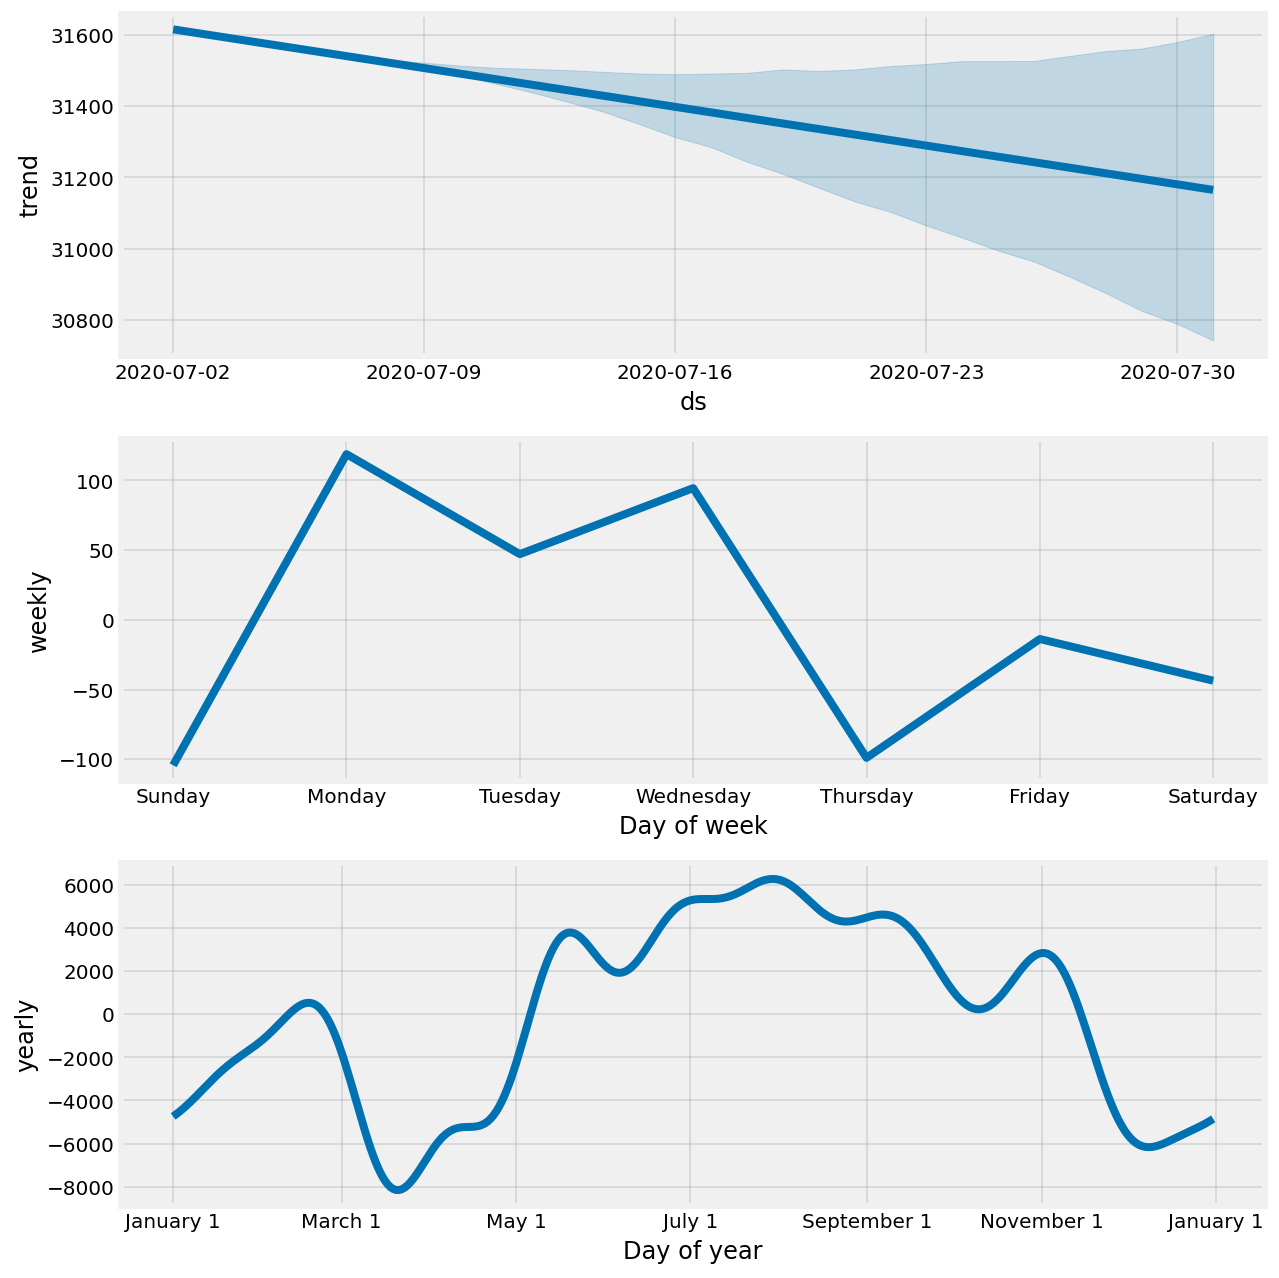

In [43]:
# Plot the Prophet forecast components.
fig=model2.plot_components(forecast2)

In [44]:
# RMSE Error
error_fb2 = rmse(test['y'], forecast2['yhat'])
print(f'FB prophet RMSE Error: {error_fb2:4.8}')

FB prophet RMSE Error: 2642.1584


In [45]:
print('The mean of Close_SAR:',ds_test['y'].mean())

The mean of Close_SAR: 36019.09787733333


-------------

### 3. XGboost

In [46]:
# Create a new datafram as a copy of before dataframe
xg_df = before[['close_SAR']].copy()
xg_df.reset_index(inplace=True) # reset index
xg_df.drop('date',1,inplace=True) # drop date column
xg_df.head()

,close_SAR
0,35122.496000
1,34457.025024
2,34916.224000
3,33761.850880
4,31503.360000


In [47]:
# Convert this time series dataset as a supervised learning problem.
# Predict the value at the next time-step by using the value at the previous time step.
xg_df['target'] = xg_df.close_SAR.shift(-1)

In [48]:
xg_df.tail()

,close_SAR,target
812,41366.761984,40902.875008
813,40902.875008,41631.427712
814,41631.427712,41627.977344
815,41627.977344,42512.509184
816,42512.509184,NaN


In [49]:
xg_df.dropna(inplace=True) # dropping null values, which resulted from .shift(-1).
xg_df.tail()

,close_SAR,target
811,37247.247616,41366.761984
812,41366.761984,40902.875008
813,40902.875008,41631.427712
814,41631.427712,41627.977344
815,41627.977344,42512.509184


In [50]:
# split the dataframe to train and test.  
train, test = train_test_split(xg_df, 0.03658) # 30 days = 0.03658.

In [51]:
len(train) # to check

786

In [52]:
len(test) # to check

30

In [53]:
x = train[:,:-1] # train
y = train[:,-1] # target

In [54]:
# XGboost
model3 = XGBRegressor(eval_metric='rmse', n_estimators=1000)
model3.fit(x,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

### Predict

In [55]:
# prediction based on the test set.
predict3 = []
# for each value
for i in test:  
    val = np.array(i[0]).reshape(1,-1)
    pred=model3.predict(val) # predict
    predict3.append(pred[0])
    
predict3[:10] # check 

[34841.85,
 34702.68,
 34249.65,
 34622.22,
 34390.22,
 35336.492,
 35685.44,
 36262.69,
 34841.85,
 34489.992]

In [56]:
# XGBoost RMSE Error
error_XGB3 = rmse(test[:,0], predict3)
print(f'XGBoost RMSE Error: {error_XGB3:4.8}')

print('The mean of Close_SAR:',test[:,0].mean())



XGBoost RMSE Error: 1452.9825
The mean of Close_SAR: 35756.13733119999


In [57]:
# To plot test_values vs. predict_values, we need to get a datafram, which contains the values and the dates.

# Dateframe
XG_pred = pd.DataFrame(columns=['test_values', 'predict_values'])
XG_pred['test_values'] = test[:,0]
XG_pred['predict_values'] = predict3 

# Dates.
plot_XG_pred= XG_pred.set_index(ds_test.ds.index)
plot_XG_pred
plot_XG_pred.head()

,test_values,predict_values
date,,
2020-07-02,34623.692800,34841.851562
2020-07-03,34078.159616,34702.679688
2020-07-04,33972.098304,34249.648438
2020-07-05,34261.629184,34622.218750
2020-07-06,34013.915264,34390.218750


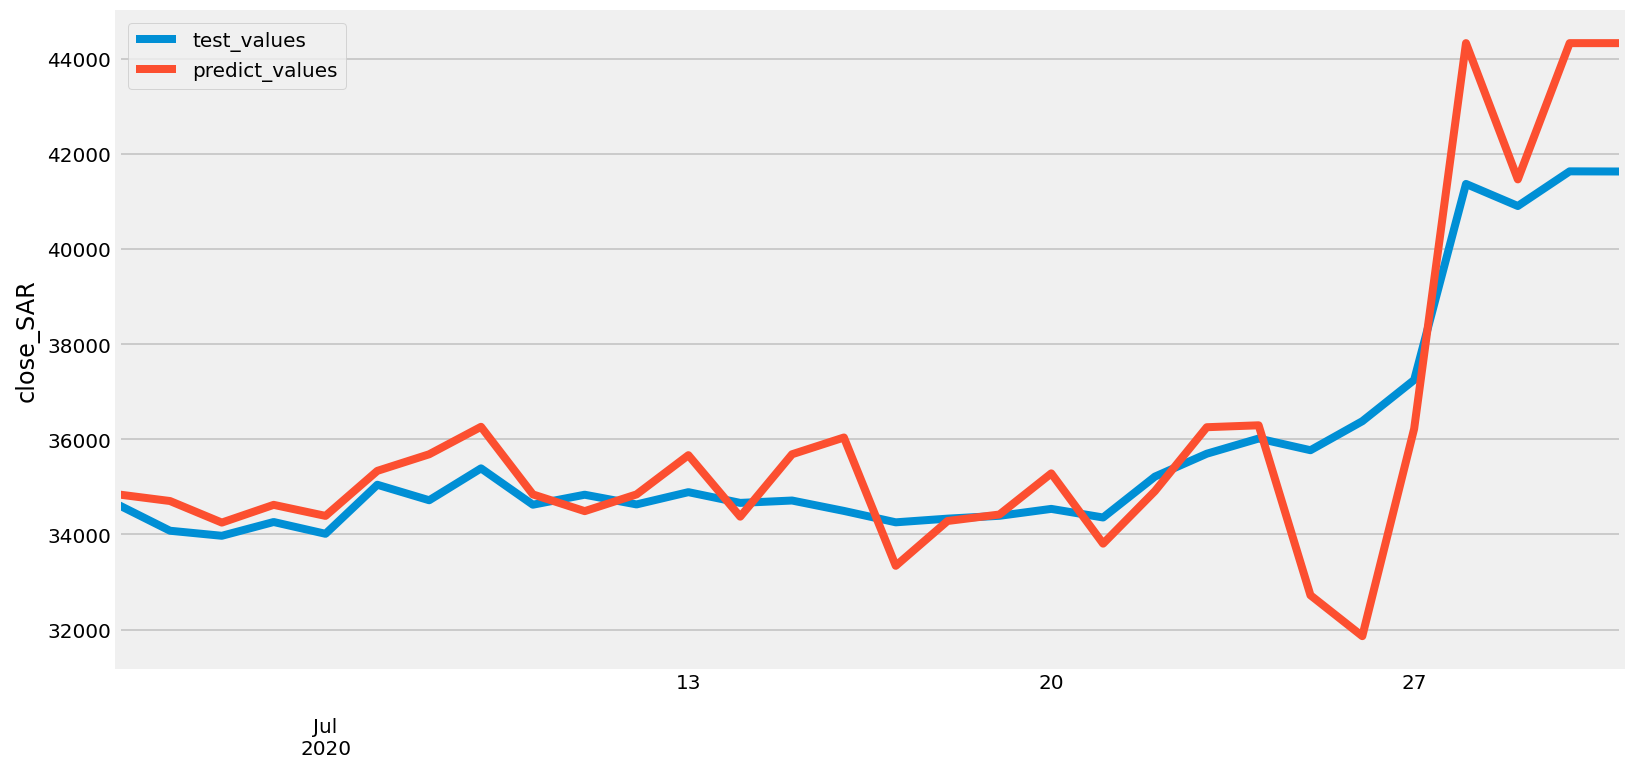

In [58]:
# plotting test_values vs. predict_values.
title = ''
ylabel='close_SAR'
xlabel=''

ax = plot_XG_pred['test_values'].plot(legend=True,figsize=(12,6),title=title)
plot_XG_pred['predict_values'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Walk-forward validation

In [59]:
# function to predict based on a value.
def xgb_predict(train, val):
    train = np.array(train)
    X, y = train[:,:-1], train[:,-1] 
    model3 = XGBRegressor(eval_metric='rmse', n_estimators=1000)
    model3.fit(X, y)
    
    val = np.array(test[0,0]).reshape(1,-1)
    pred=model3.predict(val)
    return pred[0]
    

In [60]:
# function for forecasting
def validate(data,perc):
    predictions = []
    train, test = train_test_split(data, perc)
    
    history = [x for x in train] # initilizing the history by the train set.
    
    for i in range (len(test)):
        test_x, test_y = test[i,:-1], test[i,-1]
        pred = xgb_predict(history, test_x[0])
        predictions.append(pred)
        history.append(test[i]) # add the test set to the history.
    error = rmse(test[:,-1], predictions) # get RMSE Error
    return error, test[:,-1] , predictions # return RMSE Error, testset (Close_SAR), forcasting values.

In [61]:
# Call the forecasting function with specified the number of future days (0.03658)
rmse, y , pred3 = validate(xg_df,0.03658) 
print('RMSE Error:',rmse)
print('The mean of Close_SAR:',y.mean())

RMSE Error: 3245.0330372270173
The mean of Close_SAR: 36019.097877333326


### Plotting the Close_SAR forecast

In [62]:
# Create new dataframe that contains train, test sets with their dates.
train_XG_pred=  pd.DataFrame(columns=['test_values','predict_values']) # new dataframe.
train_XG_pred['test_values']= ds_train['y'] # get train set with dates.
train_XG_pred['predict_values']= ds_train['y'].shift(-1) # get test set and target with thier dates
train_XG_pred.dropna(inplace=True) # drop nan, wich resulted from shifting.
train_XG_pred.tail() # check that new datafram has all the train and test values and dates.


,test_values,predict_values
date,,
2020-06-26,34361.952384,33798.604800
2020-06-27,33798.604800,34189.959040
2020-06-28,34189.959040,34475.777024
2020-06-29,34475.777024,34273.217920
2020-06-30,34273.217920,34623.692800


In [63]:
# Create new dataframe that contains future dates (30 days).
future = pd.DataFrame(data= pd.date_range(start='8/1/2020' , end='8/30/2020', freq='D')) 
future['test_values']=y # fill the test values with testset (Close_SAR).
future['predict_values']=pred3 # fill the predict_values with forcasting values.
future.set_index(0,inplace=True) 
future.index.name = None

In [64]:
future.head() # check

,test_values,predict_values
2020-08-01,34078.159616,34841.851562
2020-08-02,33972.098304,34100.281250
2020-08-03,34261.629184,34091.437500
2020-08-04,34013.915264,34089.667969
2020-08-05,35044.487680,34088.484375


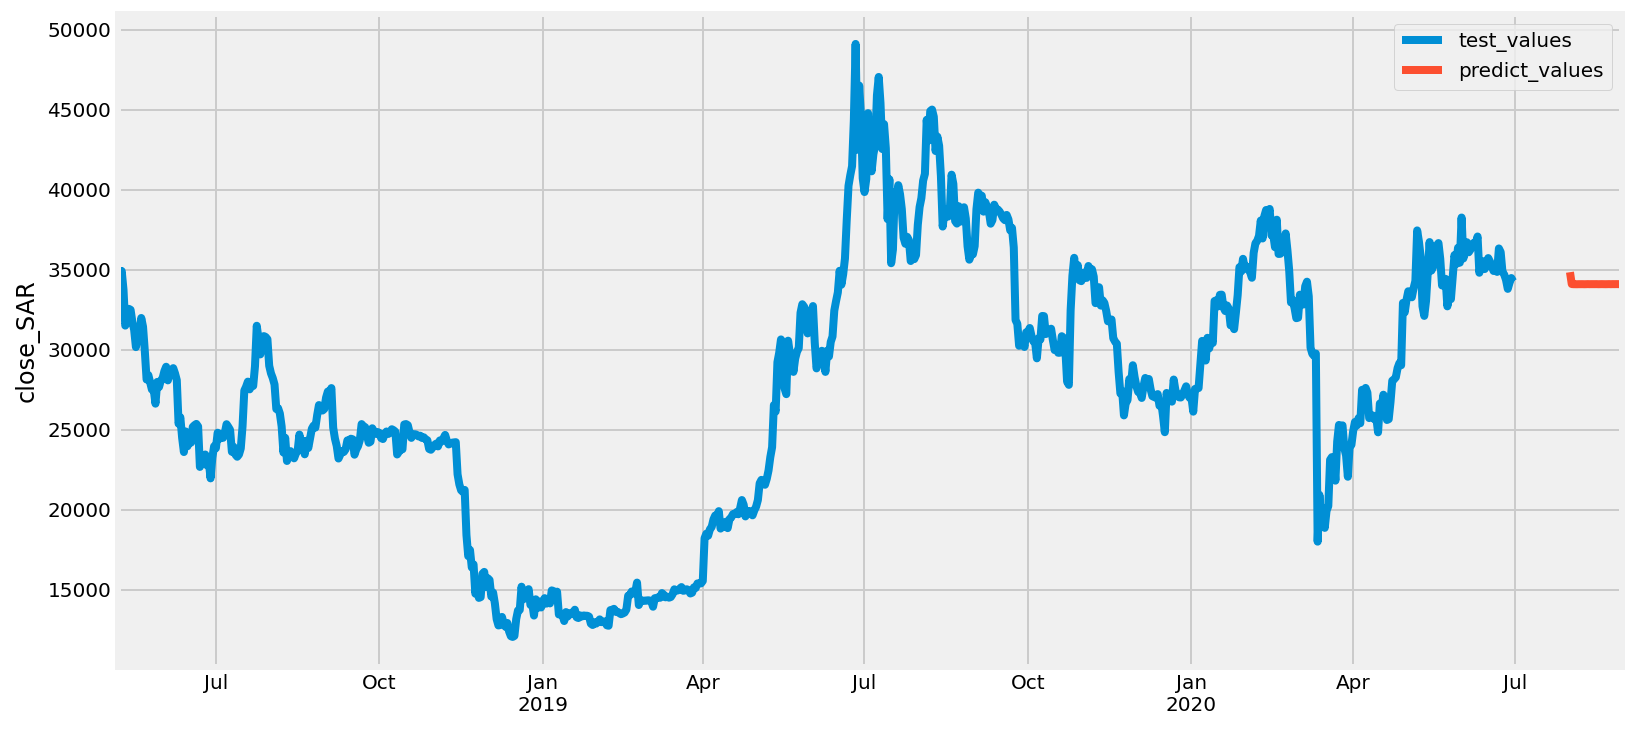

In [65]:
# plotting the Close_SAR forecast.
title = ''
ylabel='close_SAR'
xlabel=''

ax = train_XG_pred['test_values'].plot(legend=True,figsize=(12,6),title=title)
future['predict_values'].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

--------

## Appendix

Attempts to reduce RMSE error:

- SARIMAX - seasonal=True - weekly resample - (without the sudden increase).
- Facebook prophet - weekly resample - (without the sudden increase).
- SARIMAX- seasonal=False - (with the sudden increase).




### SARIMAX- Weekly Resampled

In [66]:
# Weeklyresample.
weekly_summary = pd.DataFrame()
weekly_summary['close_SAR'] = before.close_SAR.resample('W').mean()
weekly_summary.head()

,close_SAR
date,
2018-05-13,33437.714523
2018-05-20,31341.064119
2018-05-27,28698.735872
2018-06-03,28019.002661
2018-06-10,28032.675547


<AxesSubplot:xlabel='date'>

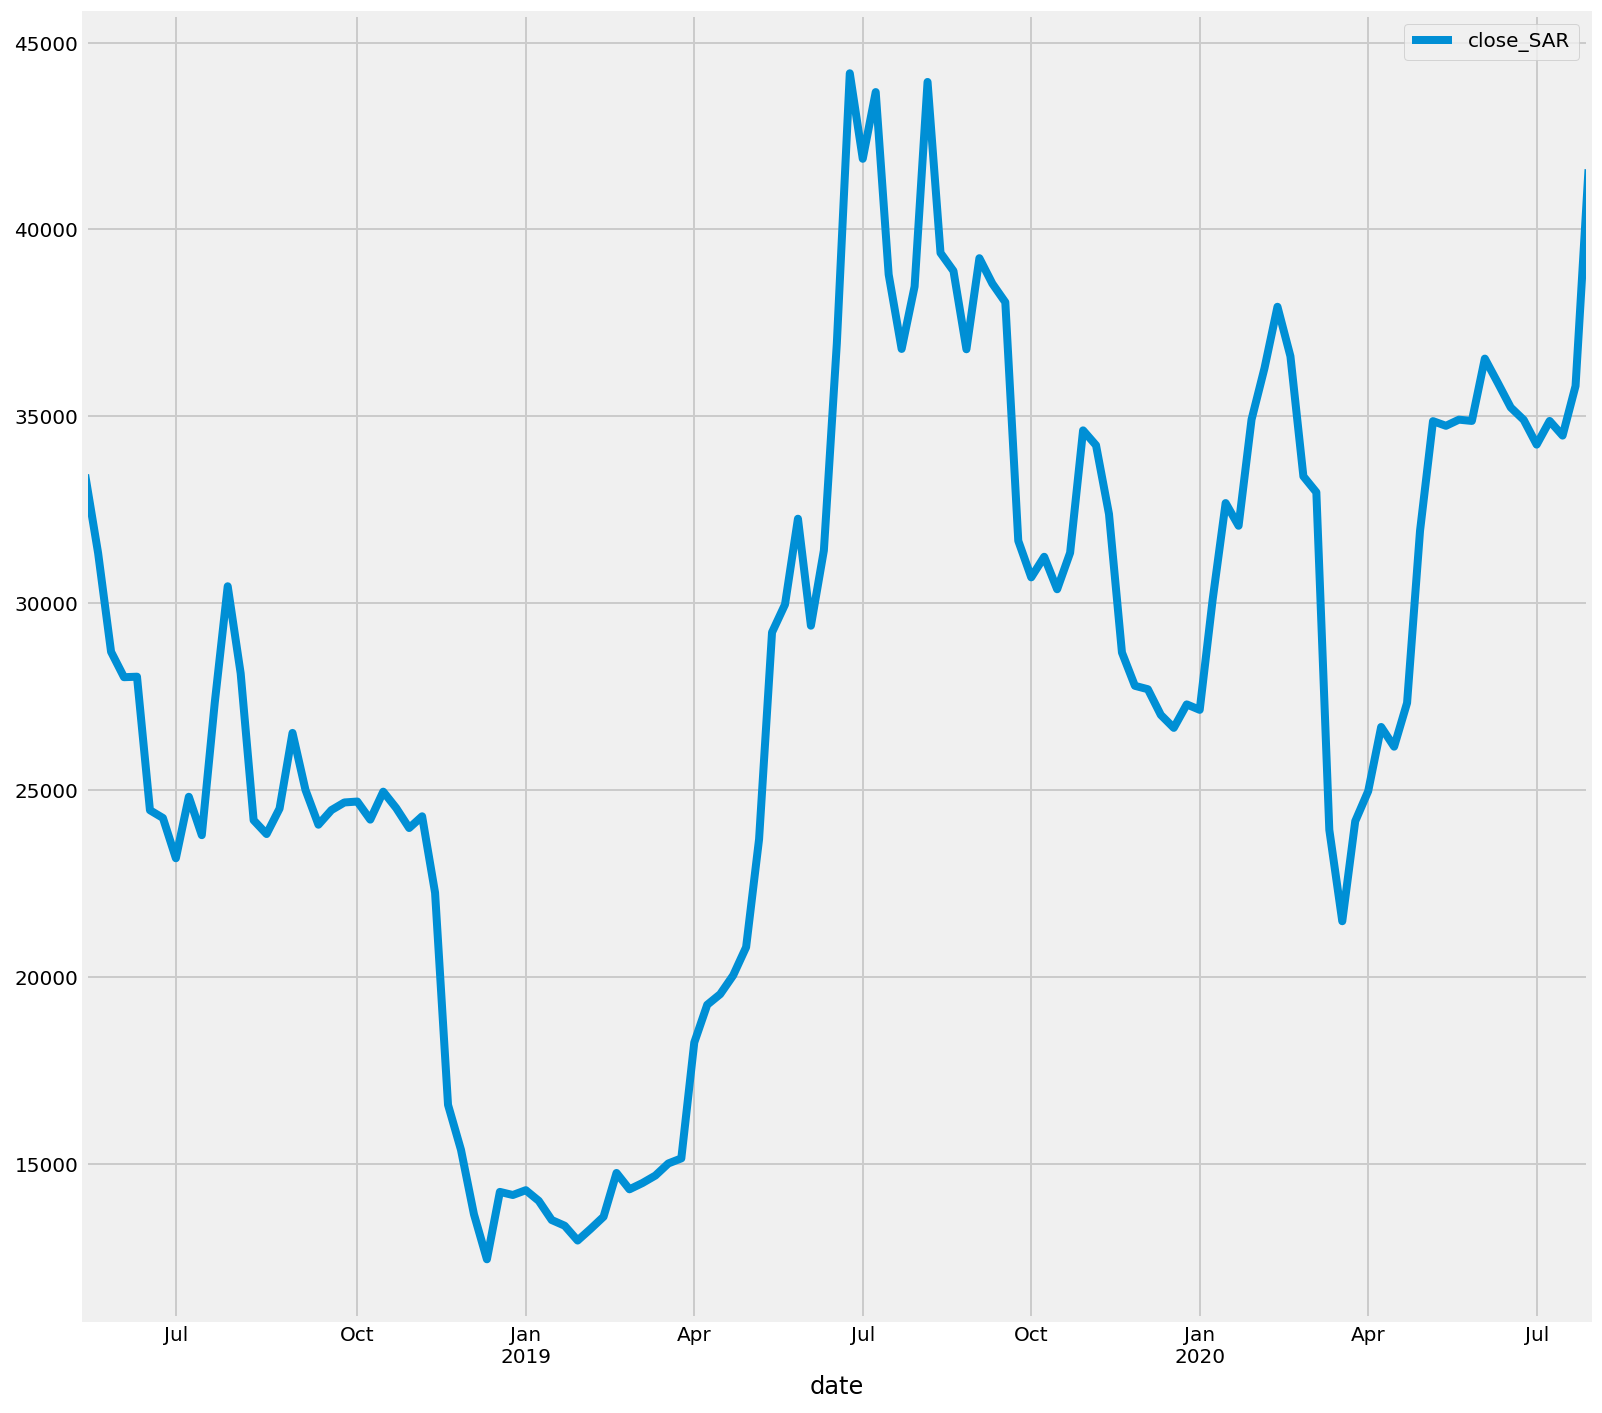

In [67]:
# plotting the target.
fig, ax = plt.subplots(figsize=(12, 12))
weekly_summary.plot(ax= ax)

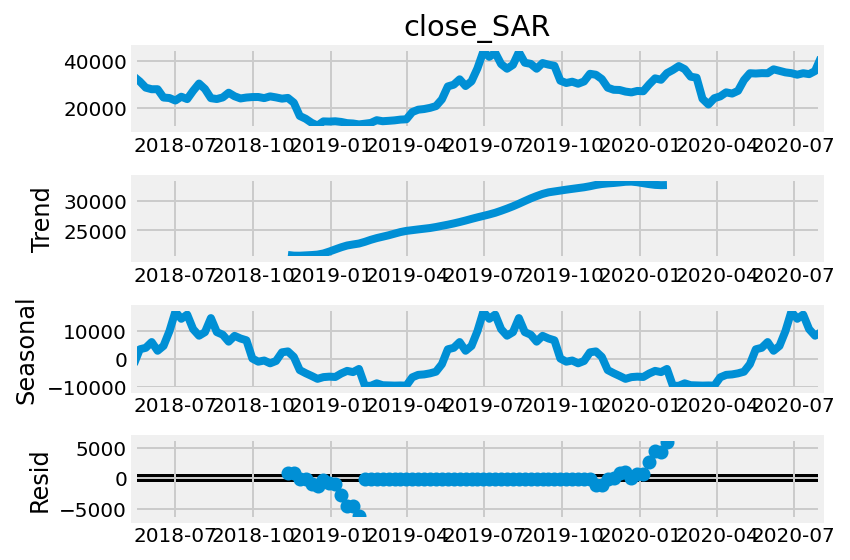

In [68]:
# plot the seasonlity
result = seasonal_decompose(weekly_summary['close_SAR'])
result.plot();

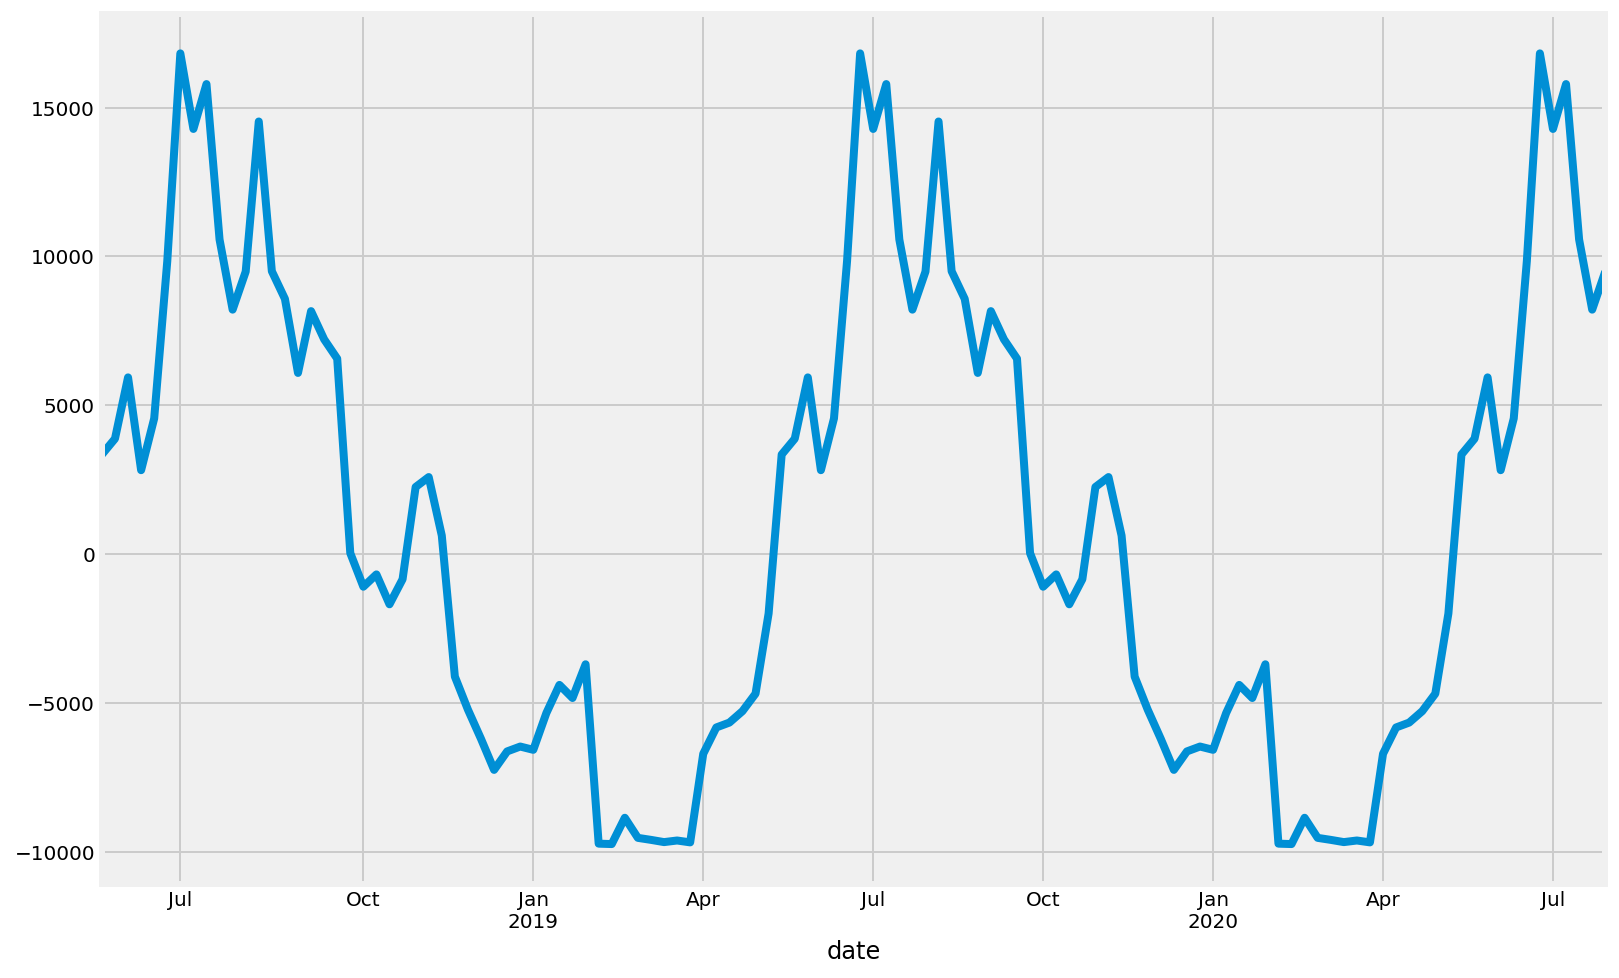

In [69]:
# plot the seasonlity in a higher scale
ax=result.seasonal[1:150].plot(figsize=(12,8))

In [70]:
# checking the stationary
adf_test(weekly_summary['close_SAR'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.548139
p-value                   0.509578
# lags used               1.000000
# observations          115.000000
critical value (1%)      -3.488535
critical value (5%)      -2.887020
critical value (10%)     -2.580360
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [71]:
# auto_arima with seasonal= true.
auto_arima(weekly_summary['close_SAR'],seasonal=True,m=52).summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  117
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1067.360
Date:                Wed, 10 Feb 2021   AIC                           2136.719
Time:                        17:40:04   BIC                           2139.473
Sample:                             0   HQIC                          2137.837
                                - 117                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.702e+06    5.2e+05     10.969      0.000    4.68e+06    6.72e+06
===================================================================================
Ljung-Box (L1) (Q):                   5.16   Jarque-Bera (JB):                22.26
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.79   Skew:                            -0.21
Prob(H) (two-sided):                  0.07   Kurtosis:                         5.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [72]:
# to split dataset to train and test
len(weekly_summary)-5

df_train = weekly_summary.iloc[:112]
df_test = weekly_summary.iloc[112:]

In [73]:
len(df_train),len(df_test) # to check

(112, 5)

In [74]:
# SARIMAX model
model4 = SARIMAX(df_train['close_SAR'],order=(0,1,0))
results4 = model4.fit()
results4.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              close_SAR   No. Observations:                  112
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1020.688
Date:                Wed, 10 Feb 2021   AIC                           2043.377
Time:                        17:40:32   BIC                           2046.086
Sample:                    05-13-2018   HQIC                          2044.476
                         - 06-28-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.632e+06   5.22e+05     10.788      0.000    4.61e+06    6.65e+06
===================================================================================
Ljung-Box (L1) (Q):                   5.02   Jarque-Bera (JB):                22.29
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                            -0.27
Prob(H) (two-sided):                  0.15   Kurtosis:                         5.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### prediction

In [75]:
# prediction
start=len(df_train)
end=len(df_train)+len(df_test)-1
predictions4 = results4.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX(0,1,0) Predictions')

In [76]:
from statsmodels.tools.eval_measures import rmse
error4 = rmse(df_test['close_SAR'], predictions4)
print(f'Weekly Resampled RMSE Error: {error4:4.8}')
print('The mean of Close_SAR:',weekly_summary['close_SAR'].mean())

Weekly Resampled RMSE Error: 3045.8904
The mean of Close_SAR: 27749.71181473601


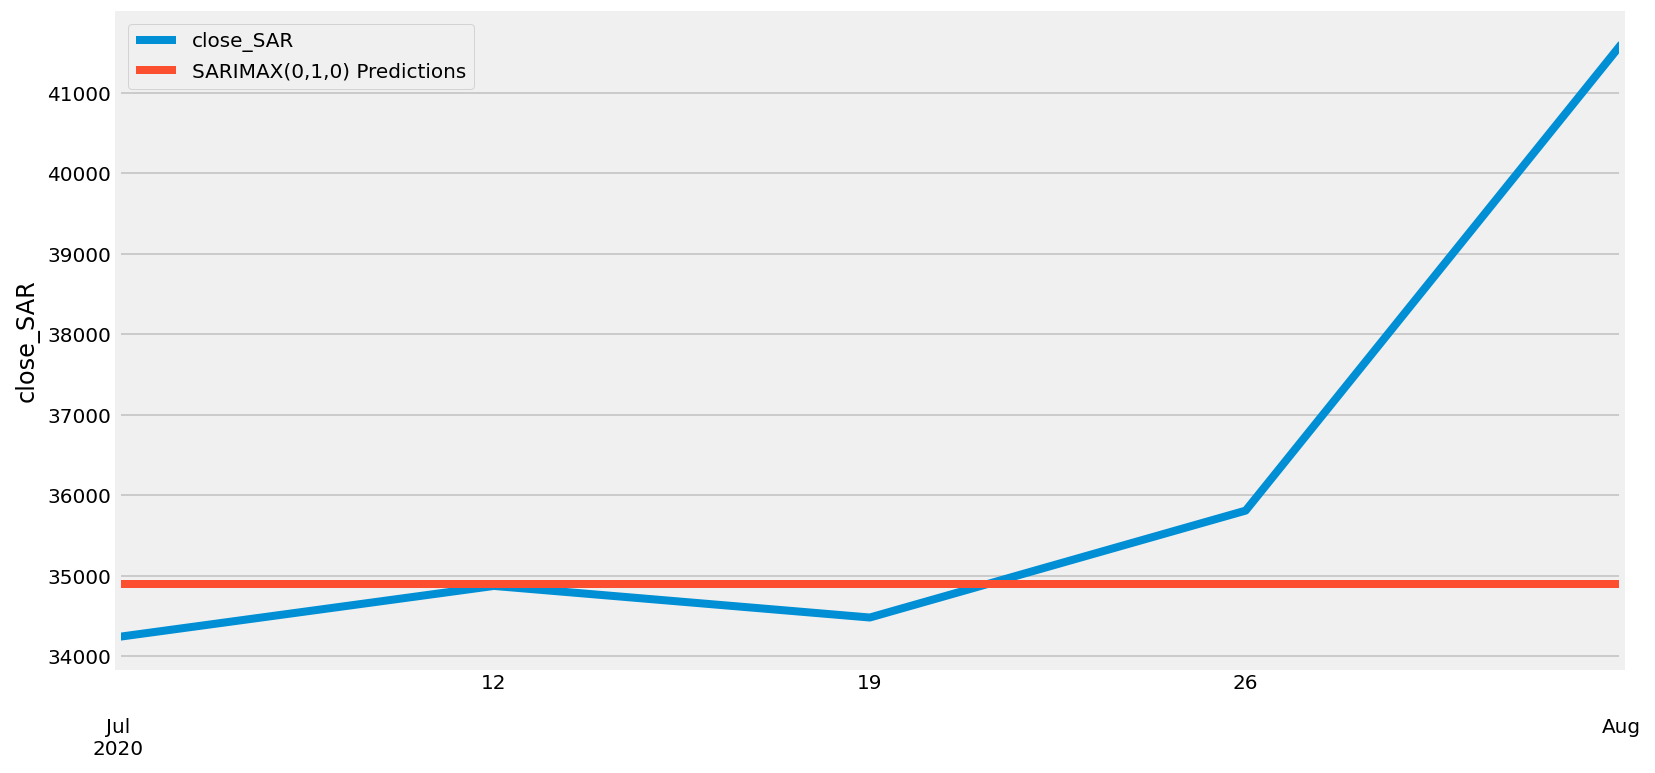

In [77]:
# Plot predictions against true values
title = ''
ylabel='close_SAR'
xlabel=''


ax = df_test['close_SAR'].plot(legend=True,figsize=(12,6),title=title)
predictions4.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Forecasting

In [78]:
# Forecasting
fcast4 = results4.predict(start=len(weekly_summary),end=len(weekly_summary)+5,typ='levels',dynamic=False).rename('SARIMAX(0, 1, 0) Forecast')

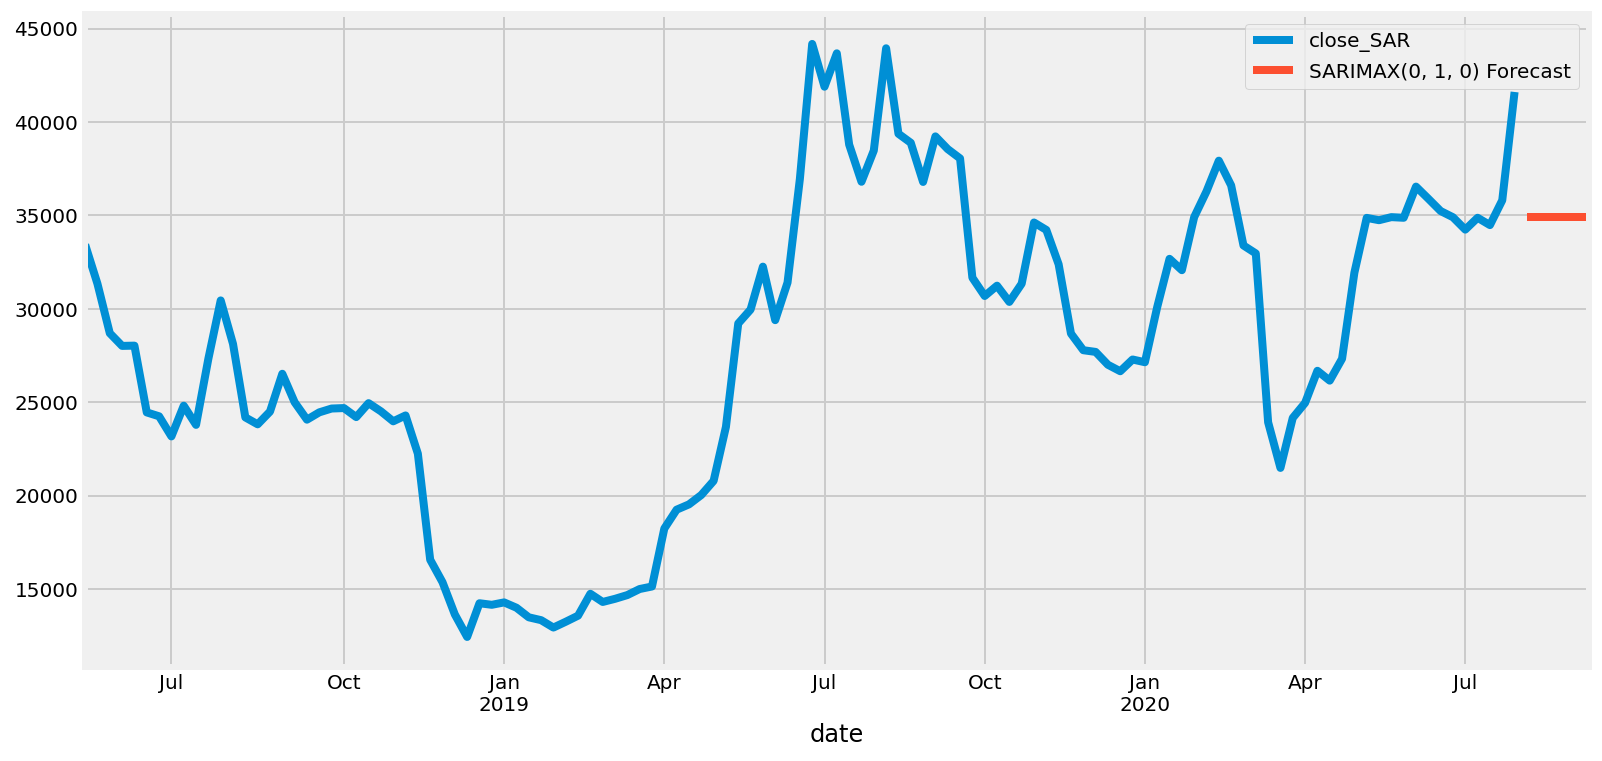

In [79]:
# plot forcasting
title = ''
ax = weekly_summary['close_SAR'].plot(legend=True,figsize=(12,6),title=title)
fcast4.plot(legend=True);

---------

## Facebook prophet


In [80]:
# Satisfying Facebook prophet format for train set.
ds_train = df_train.copy()
ds_train['ds'] = df_train.index
ds_train.head()

,close_SAR,ds
date,,
2018-05-13,33437.714523,2018-05-13
2018-05-20,31341.064119,2018-05-20
2018-05-27,28698.735872,2018-05-27
2018-06-03,28019.002661,2018-06-03
2018-06-10,28032.675547,2018-06-10


In [81]:
# Satisfying Facebook prophet format
ds_train = ds_train.rename(columns={'close_SAR': 'y'})
ds_train.head()

,y,ds
date,,
2018-05-13,33437.714523,2018-05-13
2018-05-20,31341.064119,2018-05-20
2018-05-27,28698.735872,2018-05-27
2018-06-03,28019.002661,2018-06-03
2018-06-10,28032.675547,2018-06-10


In [82]:
# Facebook prophet model 
model5 = Prophet()
model5.fit(ds_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [83]:
# Satisfying Facebook prophet format for test set.
ds_test = df_test.copy()
ds_test['ds'] = df_test.index
ds_test.head()

,close_SAR,ds
date,,
2020-07-05,34242.641445,2020-07-05
2020-07-12,34876.148297,2020-07-12
2020-07-19,34484.060050,2020-07-19
2020-07-26,35812.017755,2020-07-26
2020-08-02,41608.310246,2020-08-02


In [84]:
# Satisfying Facebook prophet format
ds_test = ds_test.rename(columns={'close_SAR': 'y'})
ds_test.tail()

,y,ds
date,,
2020-07-05,34242.641445,2020-07-05
2020-07-12,34876.148297,2020-07-12
2020-07-19,34484.060050,2020-07-19
2020-07-26,35812.017755,2020-07-26
2020-08-02,41608.310246,2020-08-02


### Prediction

In [85]:
# predictions
pred5 = model5.predict(ds_test)
pred5.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-07-05,36360.360210,40237.406516,49638.001250,36360.225739,36360.360210,8647.631881,8647.631881,8647.631881,8647.631881,8647.631881,8647.631881,0.0,0.0,0.0,45007.992091
1,2020-07-12,36501.083669,41553.966770,50913.911055,36498.798724,36502.706378,9403.717611,9403.717611,9403.717611,9403.717611,9403.717611,9403.717611,0.0,0.0,0.0,45904.801280
2,2020-07-19,36641.807129,41077.922477,51121.793807,36635.597648,36646.165389,9701.599258,9701.599258,9701.599258,9701.599258,9701.599258,9701.599258,0.0,0.0,0.0,46343.406387
3,2020-07-26,36782.530588,41820.554191,51543.054037,36772.081619,36790.598151,9827.828923,9827.828923,9827.828923,9827.828923,9827.828923,9827.828923,0.0,0.0,0.0,46610.359512
4,2020-08-02,36923.254048,41584.512672,51305.457590,36907.226074,36935.254685,9637.476343,9637.476343,9637.476343,9637.476343,9637.476343,9637.476343,0.0,0.0,0.0,46560.730391


<AxesSubplot:xlabel='ds'>

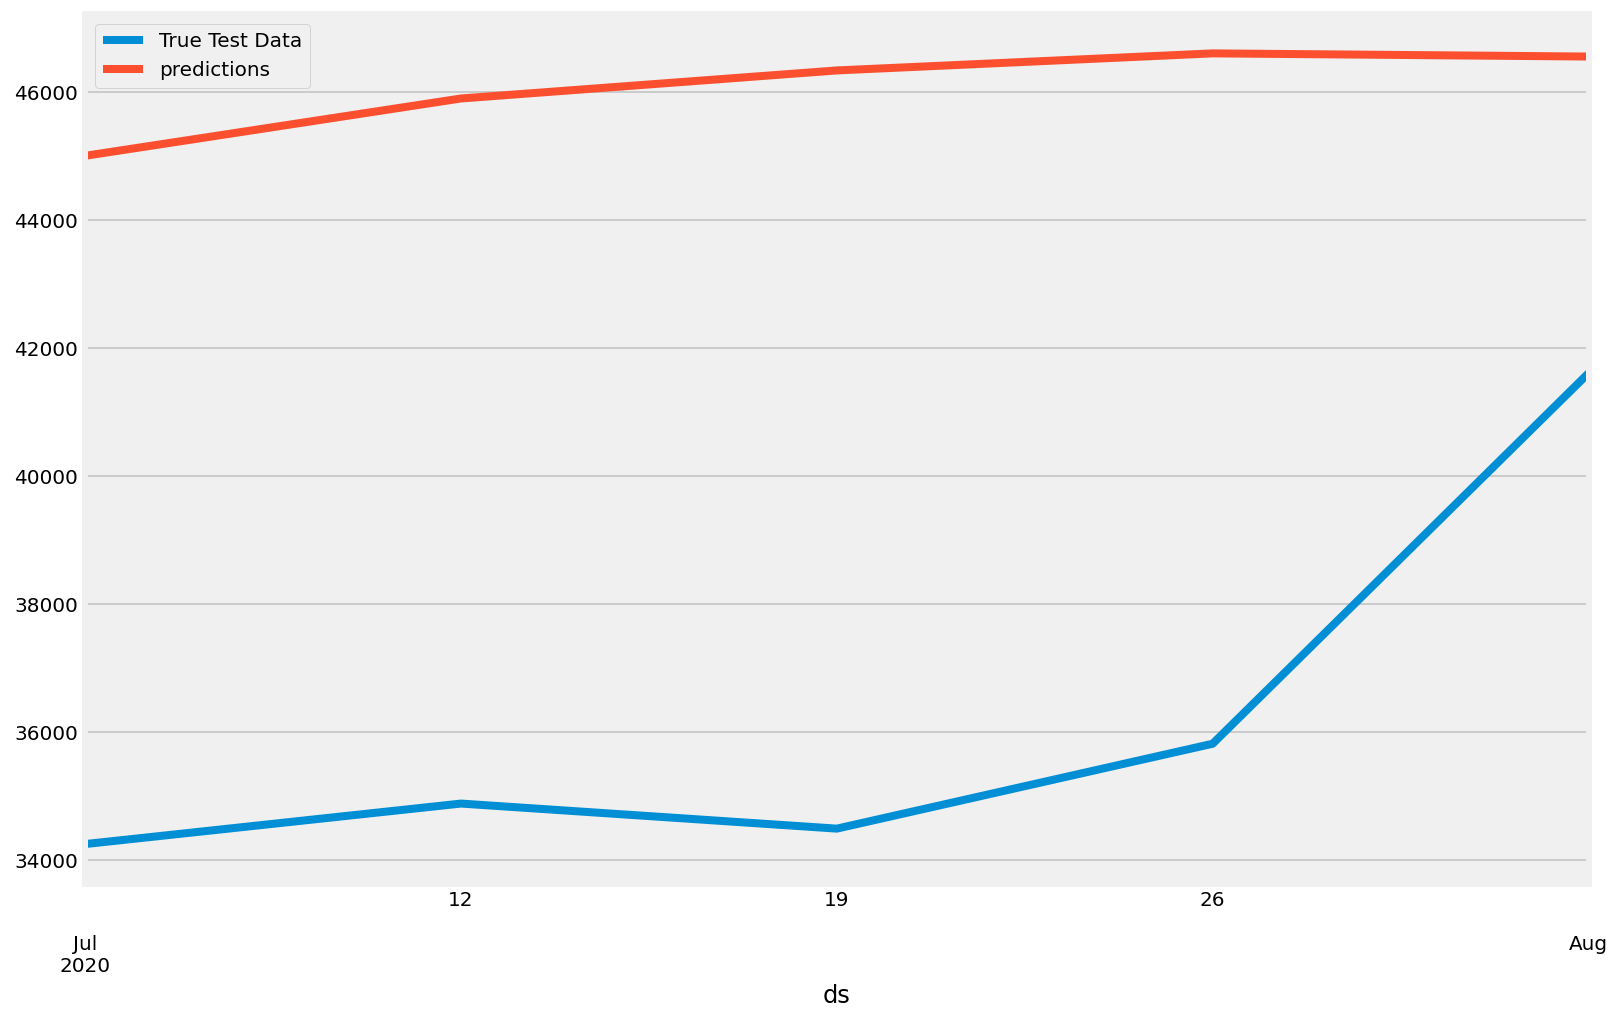

In [86]:
# Plot predictions against test values 
ax=ds_test.plot(x='ds',y='y',legend=True,label='True Test Data',figsize=(12,8)) # yhat = predict close_SAR
pred5.plot(x='ds',y='yhat',legend=True,label='predictions',ax=ax)


### Forecasting

In [87]:
# forecasting
future5=model5.make_future_dataframe(periods=5,freq='W', include_history=False) # specifying 5 weeks prediction
forecast5=model5.predict(future5)
forecast5.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-07-05,36360.360210,40617.996961,49643.373805,36360.262264,36360.439400,8647.631881,8647.631881,8647.631881,8647.631881,8647.631881,8647.631881,0.0,0.0,0.0,45007.992091
1,2020-07-12,36501.083669,41009.553586,50862.840231,36498.119036,36502.985275,9403.717611,9403.717611,9403.717611,9403.717611,9403.717611,9403.717611,0.0,0.0,0.0,45904.801280
2,2020-07-19,36641.807129,41851.879389,50909.479936,36634.235326,36646.946586,9701.599258,9701.599258,9701.599258,9701.599258,9701.599258,9701.599258,0.0,0.0,0.0,46343.406387
3,2020-07-26,36782.530588,41678.199527,51103.008716,36769.401637,36791.683092,9827.828923,9827.828923,9827.828923,9827.828923,9827.828923,9827.828923,0.0,0.0,0.0,46610.359512
4,2020-08-02,36923.254048,41857.702898,51285.391737,36903.185747,36938.403126,9637.476343,9637.476343,9637.476343,9637.476343,9637.476343,9637.476343,0.0,0.0,0.0,46560.730391


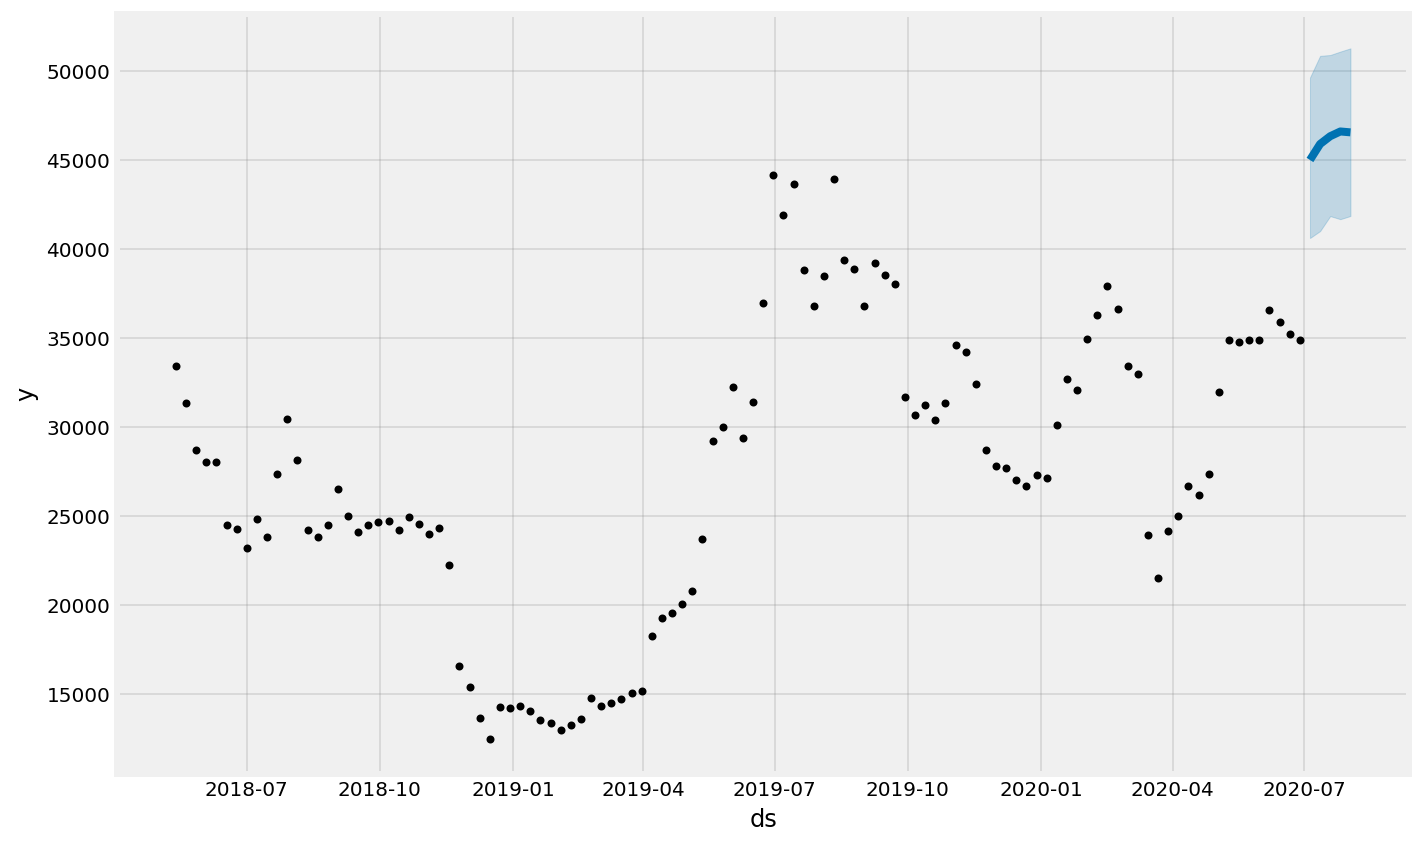

In [88]:
model5.plot(forecast5, uncertainty=True)
plt.show()


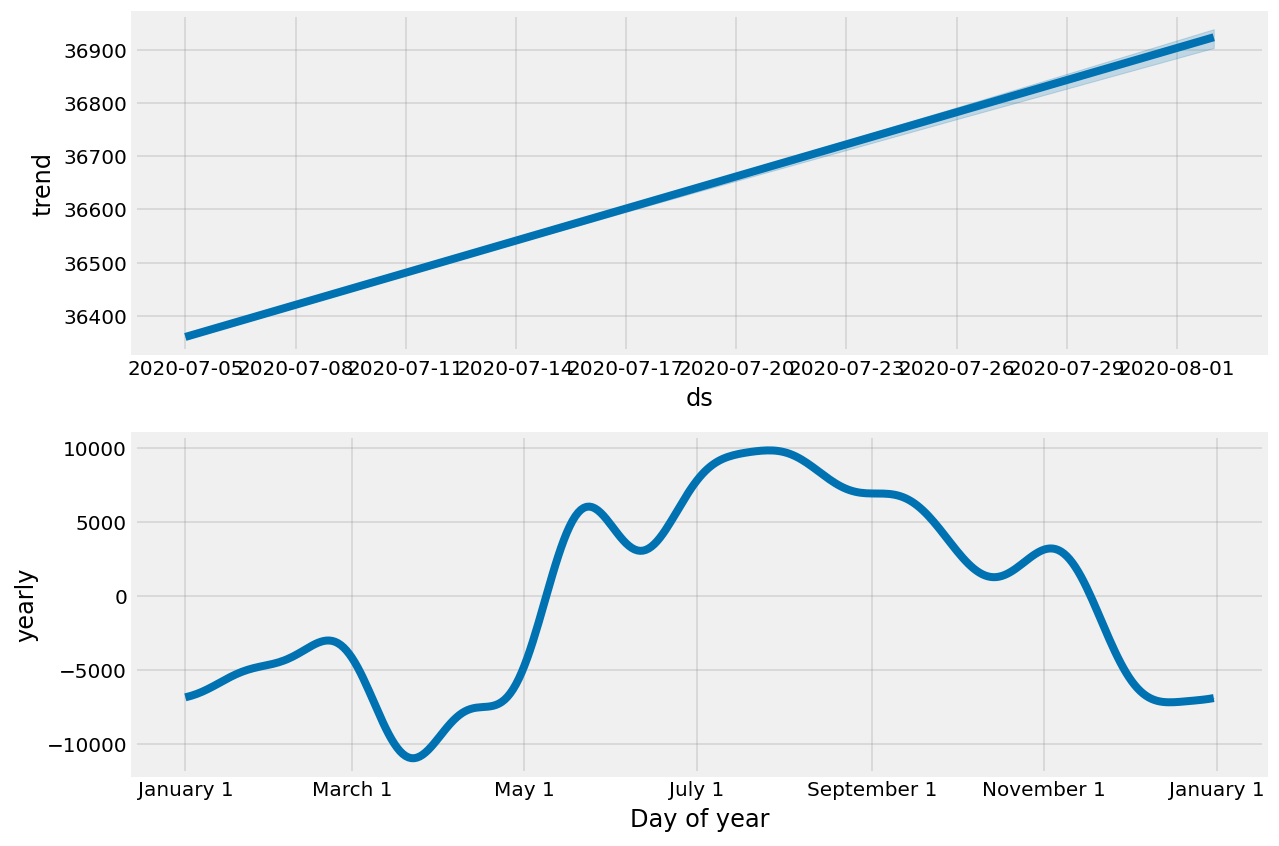

In [89]:
# Plot the Prophet forecast components.
fig=model5.plot_components(forecast5)

In [90]:
# RMSE Error
error1_fb5 = rmse(ds_test['y'], forecast5['yhat'])
print(f'FB prophet RMSE Error: {error1_fb5:4.8}')
print('The mean of Close_SAR:',ds_test['y'].mean())

FB prophet RMSE Error: 10191.16
The mean of Close_SAR: 36204.63555876571


## SARIMAX model


###  Using Auto-ARIMA to determine (p,d,q), seasonal=False

In [91]:
auto_fit = auto_arima(df['close_SAR'], start_p=0, start_q=0,
                          max_p=2, max_q=2, 
                          m=1,                     # m is used for seasonality, m=1 means no seasonality (cover this later)
                          seasonal=False,          # We do not want seasonality here
                          d=None,  # The order of first-differencing. If None (by default), automatically be selected
                          trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

auto_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=18406.442, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=18183.031, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=18404.444, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=18095.229, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=18093.186, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=18181.025, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.30 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 2.264 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(2, 2, 0)   Log Likelihood               -9043.593
Date:                Wed, 10 Feb 2021   AIC                          18093.186
Time:                        17:42:05   BIC                          18107.904
Sample:                             0   HQIC                         18098.780
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5658      0.010    -57.770      0.000      -0.585      -0.547
ar.L2         -0.2736      0.010    -28.551      0.000      -0.292      -0.255
sigma2      4.196e+06   5.18e+04     81.002      0.000    4.09e+06     4.3e+06
===================================================================================
Ljung-Box (L1) (Q):                  13.68   Jarque-Bera (JB):             22781.89
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               9.44   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [92]:
# See what are the ranges of our data
df.index.max(), df.index.min()

(999, 0)

In [93]:
len(df)-30

970

In [94]:
df_train = df.iloc[:970]
df_test = df.iloc[970:]

len(df_train),len(df_test)

(970, 30)

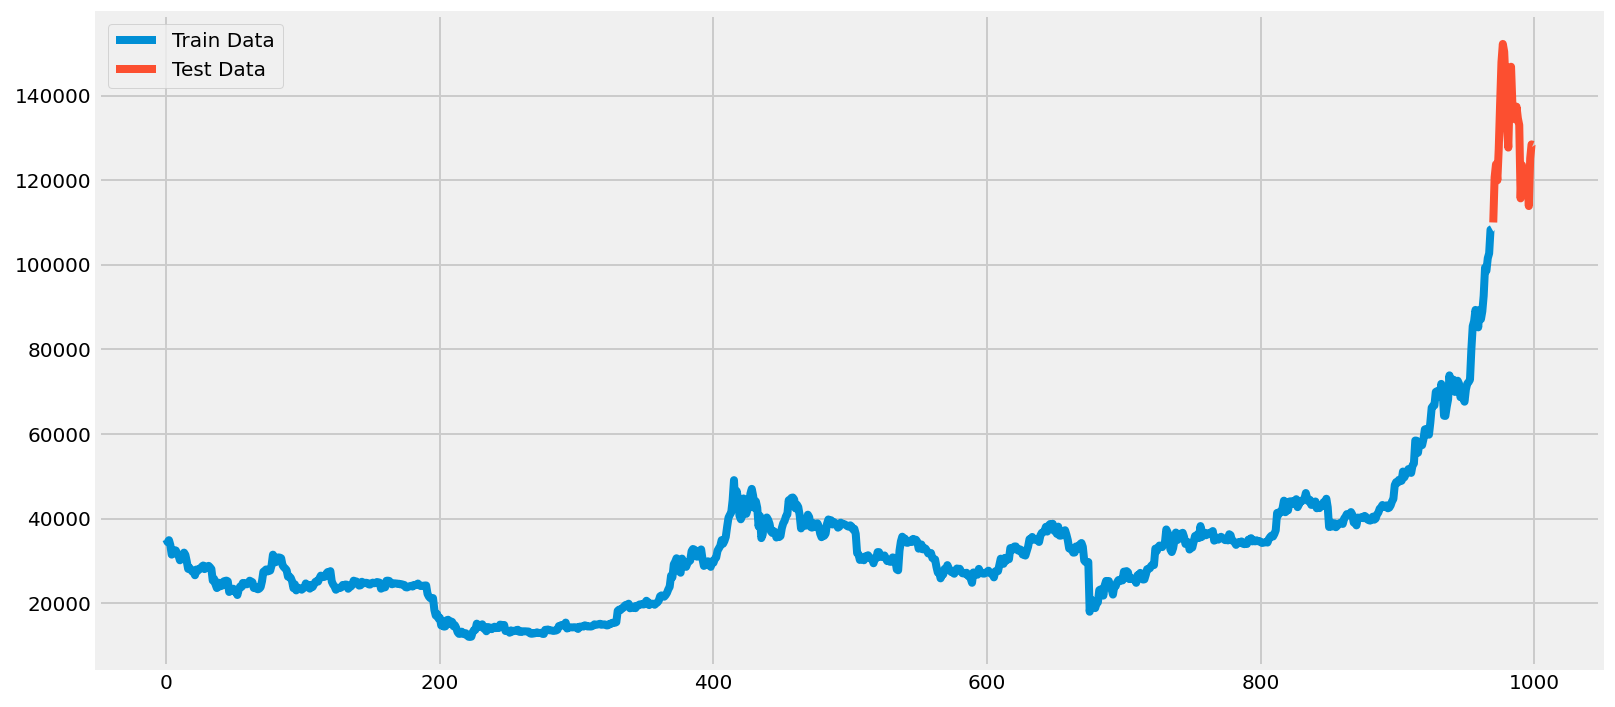

In [95]:
# Plot the train and test sets on the axis ax
fig, ax = plt.subplots(figsize=(12,6))
df_train['close_SAR'].plot(ax=ax)
df_test['close_SAR'].plot(ax=ax)
ax.legend(labels=['Train Data','Test Data']);

##  Fitting SARIMAX models

In [96]:
model6 = SARIMAX(df_train['close_SAR'],order=(2,2,0))
res6 = model6.fit()
res6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              close_SAR   No. Observations:                  970
Model:               SARIMAX(2, 2, 0)   Log Likelihood               -8455.431
Date:                Wed, 10 Feb 2021   AIC                          16916.862
Time:                        17:42:39   BIC                          16931.487
Sample:                             0   HQIC                         16922.429
                                - 970                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6342      0.010    -65.013      0.000      -0.653      -0.615
ar.L2         -0.2877      0.009    -31.605      0.000      -0.305      -0.270
sigma2      2.096e+06   4.01e+04     52.261      0.000    2.02e+06    2.18e+06
===================================================================================
Ljung-Box (L1) (Q):                  16.25   Jarque-Bera (JB):              3497.77
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.56   Skew:                            -0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

###  Predict values on the test dataset

In [97]:
# prediction
start = len(df_train) 
end = len(df_train) + len(df_test) -1
predictions6 = res6.predict(start, end,typ ='levels',dynamic=False) 

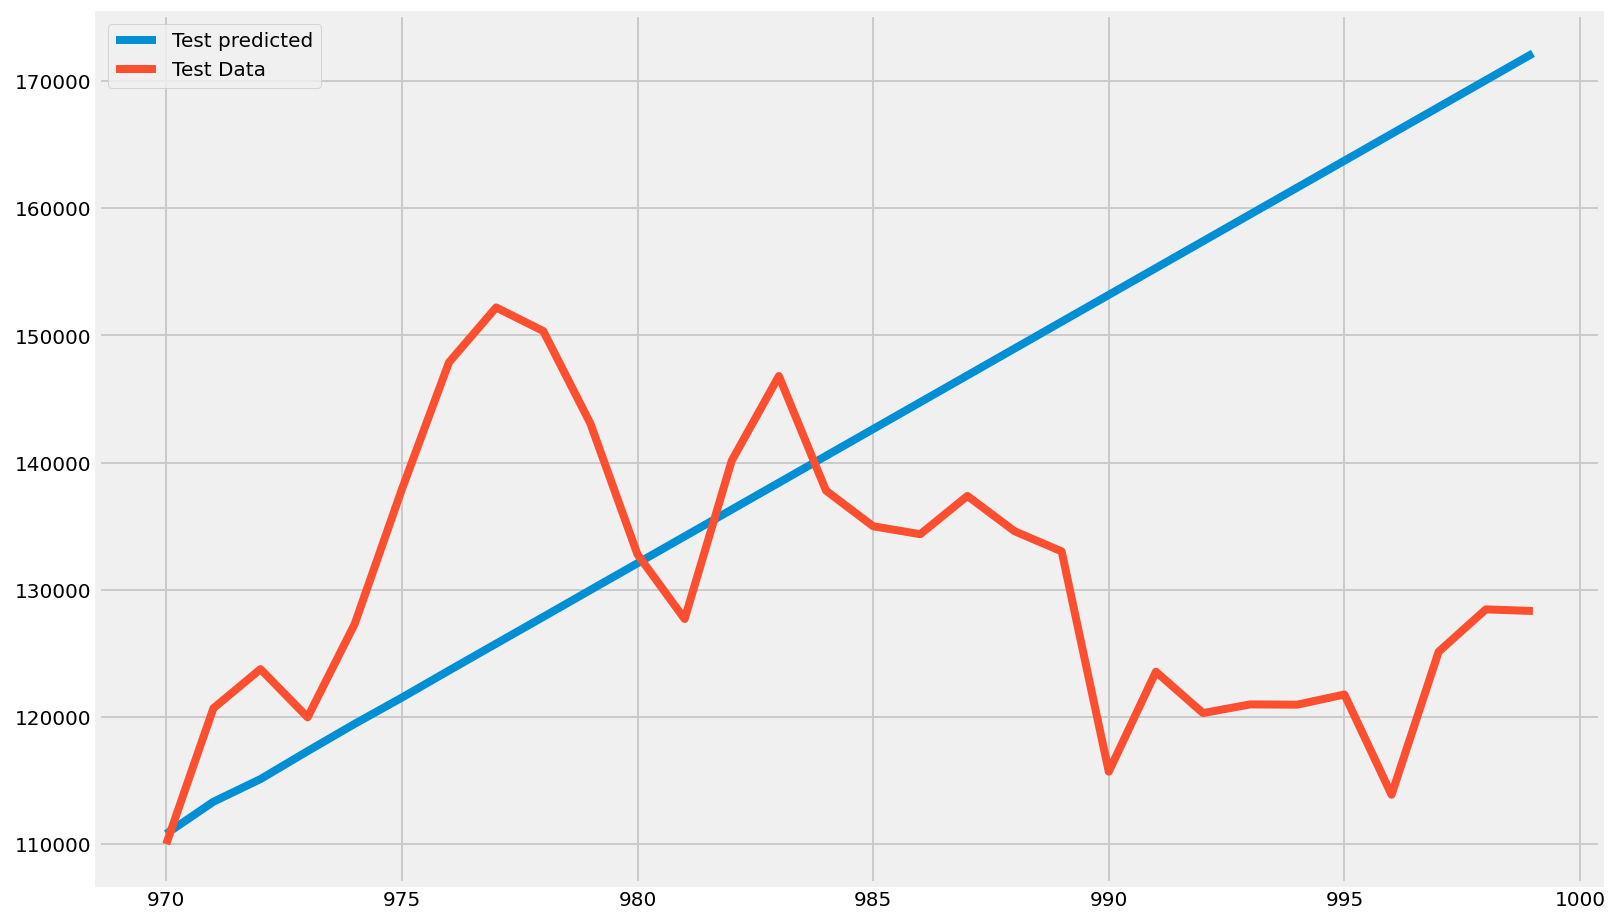

In [98]:
# plot predictions and actual test values 
title = ''
ax=predictions6.plot(legend = True,figsize=(12,8),title=title) 
df_test['close_SAR'].plot(legend = True,ax=ax);
ax.legend(labels=['Test predicted','Test Data']);

# Evaluate the Model

In [99]:
error6 = rmse(df_test['close_SAR'], predictions6)
print(f'SARIMAX RMSE Error: {error6:11.10}')

SARIMAX RMSE Error: 25970.01666


In [100]:
print('The mean of Close_SAR:',df['close_SAR'].mean())

The mean of Close_SAR: 34917.48357184002


### Forcasting for 30 days 


In [101]:
fcast6 = res6.predict(start=len(df),end=len(df)+30,typ='levels',dynamic=False).rename('ARIMA(2,2,0) Forecast')

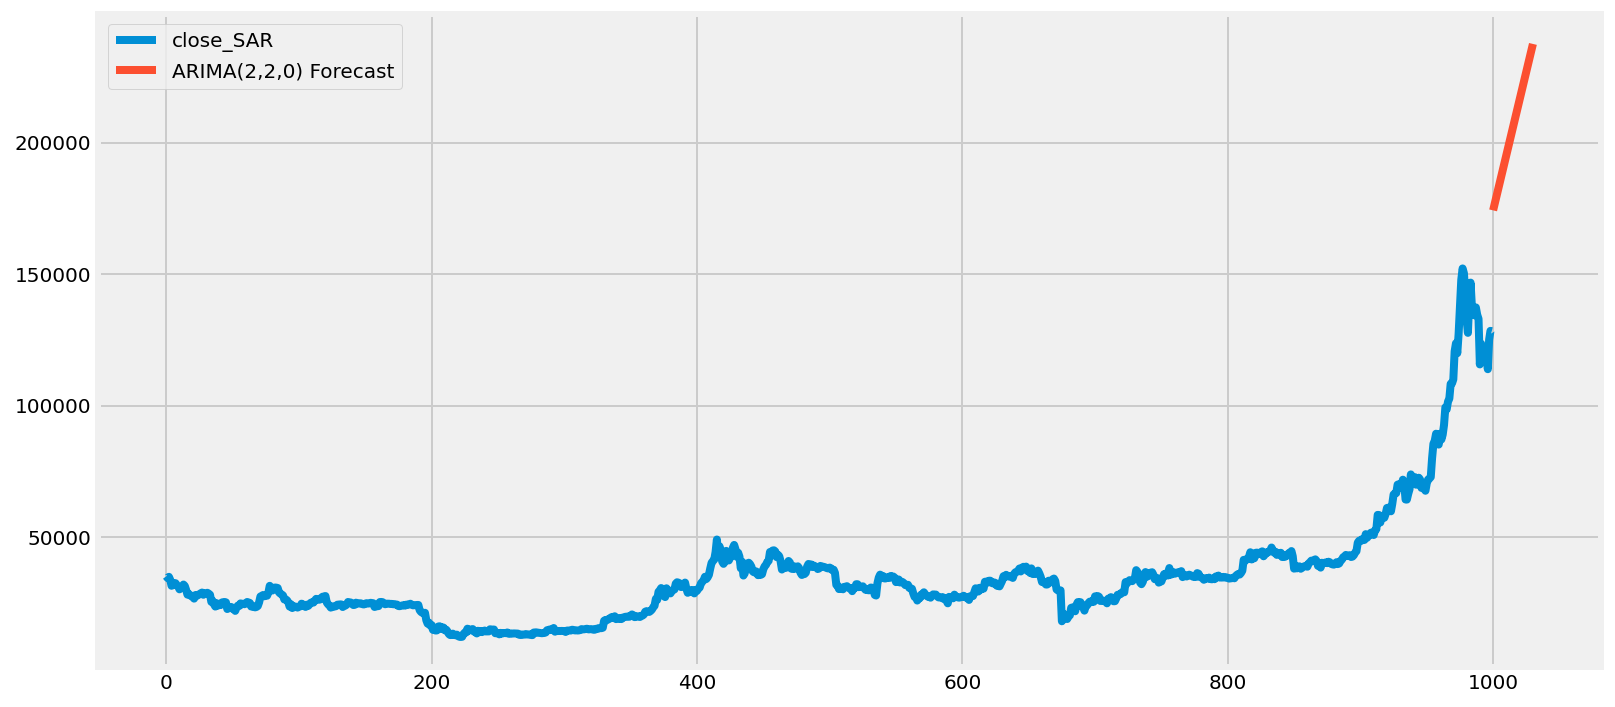

In [102]:
# plot forcasting
title = ''
ax = df['close_SAR'].plot(legend=True,figsize=(12,6),title=title)
fcast6.plot(legend=True);
